# Simulate Fragment Collisions
*Austin Keller, 2017-05-27*

There is a tradeoff in the acquisition of LC-MS/MS data between precursor selectivity, fragment ion resolution, and precursor coverage. Each of these measures can be increased at the expense of time which is limited by the elution time of a single chromatographic peak.
Here we demonstrate the tradeoffs between precursor specificity and fragment ion resolution by simulating fragment ion collisions. That is, when a fragment ion of a peptide can no longer be resolved as separate from fragments of at least one other peptide. This metric can then be conveniently expressed as a percentage of the total number of transitions that have interference (or conversely are interference free). This in part reproduces the work of Gillet et al. and applies the problem to the Thorium instrument.

Gillet, L. C., Navarro, P., Tate, S., Rost, H., Selevsek, N., Reiter, L., … Aebersold, R. (2012). Targeted Data Extraction of the MS/MS Spectra Generated by Data-independent Acquisition: A New Concept for Consistent and Accurate Proteome Analysis. Molecular & Cellular Proteomics, 11(6), O111.016717-O111.016717. https://doi.org/10.1074/mcp.O111.016717

In [135]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
import sys

In [136]:
import re


def read_fasta(filename):
    header_re = re.compile("^>")
    with open(filename) as f:
        sequence = ""
        header = ""
        proteins = {
            "header": [],
            "sequence": []
        }
        for line in f.readlines():
            line = line.rstrip()
            if header_re.match(line):
                if header:
                    proteins["header"].append(header)
                    proteins["sequence"].append(sequence)
                header = line
                sequence = ""
            else:
                sequence += line
        return pd.DataFrame.from_dict(proteins)

In [137]:
def tryptic_digest(sequence, max_missed_cleavages=0):
    
    max_missed_cleavages = max(int(max_missed_cleavages), 0)
    
    cuts = [0]
    for i in range(0, len(sequence) - 1):
        if sequence[i] in 'KR' and sequence[i + 1] != 'P':
            cuts.append(i + 1)
    cuts.append(len(sequence))
    
    peps = []
    for i in range(0, len(cuts) - 1):
        for j in range(i + 1, min(i + 2 + max_missed_cleavages, len(cuts))):
            peps.append(sequence[cuts[i]:cuts[j]])
    return list(set(peps))
    
# Test
assert set(tryptic_digest('ACKDEFRLMNORPG')) == set(['ACK', 'DEFR', 'LMNORPG'])
assert set(tryptic_digest('ACKDEFRLMNORPG', max_missed_cleavages=1)) == set(['ACK', 'DEFR', 'LMNORPG', 'ACKDEFR', 'DEFRLMNORPG'])
assert set(tryptic_digest('ACKDEFRLMNORPG', max_missed_cleavages=2)) == set(['ACK', 'DEFR', 'LMNORPG', 'ACKDEFR', 'DEFRLMNORPG', 'ACKDEFRLMNORPG'])
assert set(tryptic_digest('ACKDEFRLMNORPG', max_missed_cleavages=3)) == set(['ACK', 'DEFR', 'LMNORPG', 'ACKDEFR', 'DEFRLMNORPG', 'ACKDEFRLMNORPG'])

In [138]:
from pyteomics import mass

def fragments(peptide, types=('b', 'y'), max_charge=1):
    """
    The function generates all possible m/z for fragments of types 
    `types` and of charges from 1 to `maxcharge`.
    """
    for charge in xrange(1, max_charge+1):
        for ion_type in types:
            for i in xrange(0, len(peptide)):
                if ion_type[0] in 'abc':
                    yield mass.calculate_mass(
                            peptide[:i+1], ion_type=ion_type, charge=charge)
                else:
                    yield mass.calculate_mass(
                            peptide[i:], ion_type=ion_type, charge=charge)
                    
def precursor(peptide, charge):
    return mass.calculate_mass(peptide, ion_type='M', charge=charge)
                    
# Test
# From the GPM, http://gpmdb.thegpm.org/thegpm-cgi/peptide.pl?ltype=2&npep=0&path=/gpm/archive/777/GPM77711007268.xml&uid=28714&label=gi|18652657|&homolog=28714&id=4126.1.1&proex=-1
peptide = 'ELEDSLSEEENSASTLEEAK'
calculated = list(fragments(peptide))
print(calculated)
expected = [2080.940, 1967.856, 1838.814, 1723.787, 1636.755, 1523.671, 1436.639, 1307.596, 1178.554, 1049.511, 935.468, 848.436, 777.399, 690.367, 589.319, 476.235, 347.193, 218.150, 147.113, 130.050, 243.134, 372.177, 487.203, 574.235, 687.320, 774.352, 903.394, 1032.437, 1161.479, 1275.522, 1362.554, 1433.591, 1520.623, 1621.671, 1734.755, 1863.798, 1992.840, 2063.878]
calculated = list(np.array(calculated).round(3))
print(set(calculated) - set(expected))
# This example excludes y1 and b20, so we only check that expected is contained within calculated
print(set(expected) - set(calculated))
assert len(set(expected) - set(calculated)) == 0
print(precursor(peptide, 2))

[130.04986955473998, 243.13393353187, 372.17652661984, 487.20346964367, 574.23549804794, 687.31956202507, 774.35159042934, 903.39418351731, 1032.4367766052799, 1161.4793696932502, 1275.52229713439, 1362.55432553866, 1433.59143932337, 1520.62346772764, 1621.67114619605, 1734.7552101731799, 1863.79780326115, 1992.84039634912, 2063.87751013383, 2191.97247314783, 2209.98303783153, 2080.94044474356, 1967.8563807664298, 1838.81378767846, 1723.78684465463, 1636.75481625036, 1523.67075227323, 1436.63872386896, 1307.59613078099, 1178.55353769302, 1049.51094460505, 935.4680171639101, 848.43598875964, 777.39887497493, 690.3668465706601, 589.31916810225, 476.23510412512, 347.19251103715, 218.14991794917998, 147.11280416447]
set([2209.9830000000002, 2191.9720000000002])
set([])
1105.49515715


In [139]:
## Test
#sys.stderr.write("This test is expected to fail. The expected values may not be reliable.\n")
#peptide = 'PEPTIDE'
#b_ions = [98.06009, 227.10268, 324.15544, 425.20312, 538.28718, 653.31413, 782.35672]
#y_ions = [800.36728, 703.31452, 574.27193, 477.21916, 376.17149, 263.08742, 148.06048]
#print(list(fragments(peptide)))
#calculated = np.array(list(fragments(peptide))).round(3)
#expected = np.array(b_ions + y_ions).round(3)
#print(set(expected) - set(calculated))
#print(set(calculated) - set(expected))
#assert len(set(calculated) - set(expected)) == 0
#assert len(set(expected) - set(calculated)) == 0

In [140]:
## Test
#sys.stderr.write("This test is expected to fail. The expected values may not be reliable.\n")
## From MSnbase, https://www.biostars.org/p/5015/
#calculated = list(fragments('SIGFEGDSIGR'))
#expected = [88.03931, 201.12337, 258.14483, 405.21324, 534.25583, 591.27729, 706.30423, 793.33626, 906.42032, 963.44178, 1119.54289, 175.11895, 232.14041, 345.22447, 432.25650, 547.28344, 604.30490, 733.34749, 880.41590, 937.43736, 1050.52142, 1137.55345]
#calculated = list(np.array(calculated).round(3))
#expected = list(np.array(expected).round(3))
#print(set(expected) - set(calculated))
#print(set(calculated) - set(expected))
#assert len(set(expected) - set(calculated)) == 0

# Calculating Theoretical Fragments
It seems like there are contradictory predictions made between common tools for generating b and y ion series. The errors are minimal to the third decimal place at least, so I feel confident in continuing with the pyteomics implementation.

### TODO Store the full proteome in the sql database.
and then subset the peptides, don't subset before inserting. This will require a change to the table_identifer so that it stores the subset size

In [201]:
import os
from sqlalchemy import create_engine
import itertools
from itertools import chain

# Define arguments
fasta_filename = os.path.join("fasta", "uniprot-S228C.fasta")
max_missed_cleavages = 0

subset_peptides = True

# Read fasta file
proteins = read_fasta(fasta_filename)
print("Read {} proteins".format(len(proteins)))

# In silico digest to peptide list
peptides = set(itertools.chain.from_iterable(tryptic_digest(p) for p in proteins['sequence']))
print("Digested {} proteins into {} peptides".format(len(proteins), len(peptides)))

# Cache name
cache_filename = 'simulate_fragment_collisions'

num_peptides_used = len(peptides)

if subset_peptides:
    # 20 second peak widths, 90 minute gradient
    peak_capacity = (60. / 20.) * 90.
    peak_capacity *= 0.4 # Assume extra loss due to non-ideal elutions, correlated fragments and hydrophobicity
    subset_size = int(round(len(peptides) / peak_capacity))
    total_num_peptides = len(peptides)
    np.random.seed(0)
    peptides = pd.Series(list(peptides))
    peptides = np.random.choice(peptides, subset_size, replace=False)
    peptides = set(peptides)
    num_peptides_used = len(peptides)
    print("Using subset of {} peptides ({:.1f}%)".format(len(peptides), 100. * float(len(peptides)) / total_num_peptides))
    # Use a different filename so that we don't overwrite our cache
    cache_filename += '_subset_{}'.format(subset_size)

# Cache data in sqlite database
g_engine = create_engine('sqlite:///{}'.format(cache_filename + '.sqlite3'))

Read 6723 proteins
Digested 6723 proteins into 193222 peptides
Using subset of 1789 peptides (0.9%)


In [202]:
from sqlalchemy.types import LargeBinary
import sys

# Generate precursor and fragment ion m/z's for each peptide
def generate_precursors(peptides, charges=[2], engine=None, regenerate=False):
    # Check if the results have been calculated before
    if engine is not None and engine.dialect.has_table(engine, 'precursors') and not regenerate:
        return pd.read_sql_table('precursors', engine)
    precursors = []
    for i, charge in enumerate(charges):
        for j, p in enumerate(peptides):
            sys.stdout.write("\r{0}%".format(round(100.0 * (float(i) * len(peptides) + float(j + 1)) / (len(charges) * len(peptides)), 1)))
            precursors.append((p, charge, precursor(p, charge)))
    sys.stdout.write("\n")
    precursors_df = pd.DataFrame(precursors, columns=['PeptideSeq', 'PrecursorCharge', 'PrecursorMz'])
    if engine is not None:
        precursors_df.to_sql('precursors', engine, if_exists='replace', index=False)
    return precursors_df

def generate_fragments(peptides, max_charge=1, engine=None, regenerate=False):
    # Check if the results have been calculated before
    if engine is not None and engine.dialect.has_table(engine, 'fragments') and not regenerate:
        return pd.read_sql_table('fragments', engine)
    
    fragment_spectra = []
    for i, p in enumerate(peptides):
        sys.stdout.write("\r{0}%".format(round(100.0 * float(i + 1) / len(peptides), 1)))
        fragment_spectra.append((p, np.sort(list(fragments(p, max_charge=max_charge)))))
    sys.stdout.write("\n")
    fragments_df = pd.DataFrame(fragment_spectra, columns=['PeptideSeq', 'MassArray'])
    if engine is not None:
        fragments_df.to_sql('fragments', engine, if_exists='replace', index=False, dtype={"MassArray": LargeBinary})
    return fragments_df

In [203]:
regenerate = False
g_precursors_df = generate_precursors(peptides, charges=[2], engine=g_engine, regenerate=regenerate)
g_fragments_df = generate_fragments(peptides, max_charge=1, engine=g_engine, regenerate=regenerate)

100.0%
100.0%


In [204]:
# Test
test_fragments_df = pd.read_sql_table("fragments", g_engine)
test_fragments_df["MassArray"] = test_fragments_df["MassArray"].apply(np.fromstring)

In [205]:
g_precursors_df.head()

PeptideSeq  PrecursorCharge  PrecursorMz
0              YNTLQNVK                2   490.263999
1     DENGIEIYPIFNVLPPK                2   979.517116
2             FNDVYEISR                2   571.777470
3  SSVADLASTVDSGYQNSSLK                2  1014.989648
4           YSDHIFLSLDK                2   669.340435

In [182]:
g_fragments_df.head()["MassArray"].apply(np.fromstring)

0    [147.112804164, 164.070604999, 246.181218077, ...
1    [88.039304871, 147.112804164, 175.071333275, 2...
2    [147.112804164, 164.070604999, 251.102633404, ...
3    [102.054954935, 147.112804164, 215.139018912, ...
4    [114.091340444, 175.118952174, 215.139018912, ...
Name: MassArray, dtype: object

In [183]:
test_fragments_df.head()

PeptideSeq                                          MassArray
0                 YNTLQNVK  [147.112804164, 164.070604999, 246.181218077, ...
1     SSVADLASTVDSGYQNSSLK  [88.039304871, 147.112804164, 175.071333275, 2...
2              YSDHIFLSLDK  [147.112804164, 164.070604999, 251.102633404, ...
3         TINNLLTAIFSGTKPK  [102.054954935, 147.112804164, 215.139018912, ...
4  ITAHLGAAPAMLPMISVIVHPGR  [114.091340444, 175.118952174, 215.139018912, ...

# Characterize the distributions of precursors and fragments

## Precursors

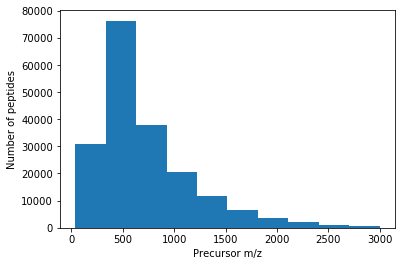

Min precursor m/z: 38.5232906689
Max precursor m/z: 38647.2544468


In [70]:
plt.hist(g_precursors_df["PrecursorMz"].loc[g_precursors_df["PrecursorMz"] < 3000.0])
plt.xlabel("Precursor m/z")
plt.ylabel("Number of peptides")
plt.show()
print("Min precursor m/z: {}".format(np.min(g_precursors_df["PrecursorMz"])))
print("Max precursor m/z: {}".format(np.max(g_precursors_df["PrecursorMz"])))

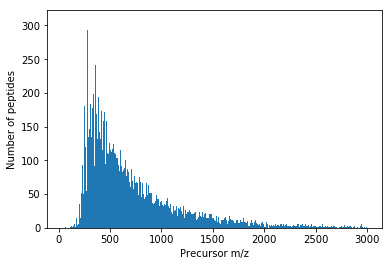

In [71]:
plt.hist(g_precursors_df["PrecursorMz"].loc[g_precursors_df["PrecursorMz"] < 3000.0], bins=6000)
plt.xlabel("Precursor m/z")
plt.ylabel("Number of peptides")
plt.show()

In [72]:
from scipy.stats import gaussian_kde


def plot_kde(df, bandwidth=None, title=None, num_points=1000, scale=1.0):
    """
    :param pandas.DataFrame df: a series of values
    :param float covariance_factor: higher values result in more smoothing
    """
    kwargs = {}
    if bandwidth is not None:
        kwargs['bw_method'] = bandwidth
    density = gaussian_kde(df, **kwargs)

    # Plotting is slow
    xs = np.linspace(np.min(df), np.max(df), num_points)
    plt.plot(xs, density(xs) * scale)
    plt.ylabel("Probability density")
    plt.xlabel("Precursor m/z")
    #plt.yscale('log', nonposy='clip')
    plt.title(title)

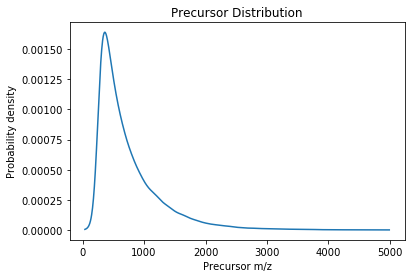

In [73]:
df = g_precursors_df['PrecursorMz'].loc[g_precursors_df["PrecursorMz"] < 5000.0]
plot_kde(df, bandwidth=0.1, title="Precursor Distribution")
plt.show()

In [74]:
# Generate data
df = g_precursors_df['PrecursorMz'].loc[g_precursors_df["PrecursorMz"] < 5000.0]
title="Simulated Precursor Distribution"
num_points = 1000
scale = 1.0
density = gaussian_kde(df)
xs = np.linspace(np.min(df), np.max(df), num_points)
y = density(xs)

density_data = pd.DataFrame([])
density_data['x'] = xs
density_data['y'] = y
subset = density_data.loc[(density_data['x'] >= 400.0) & (density_data['x'] <= 1000.0)]

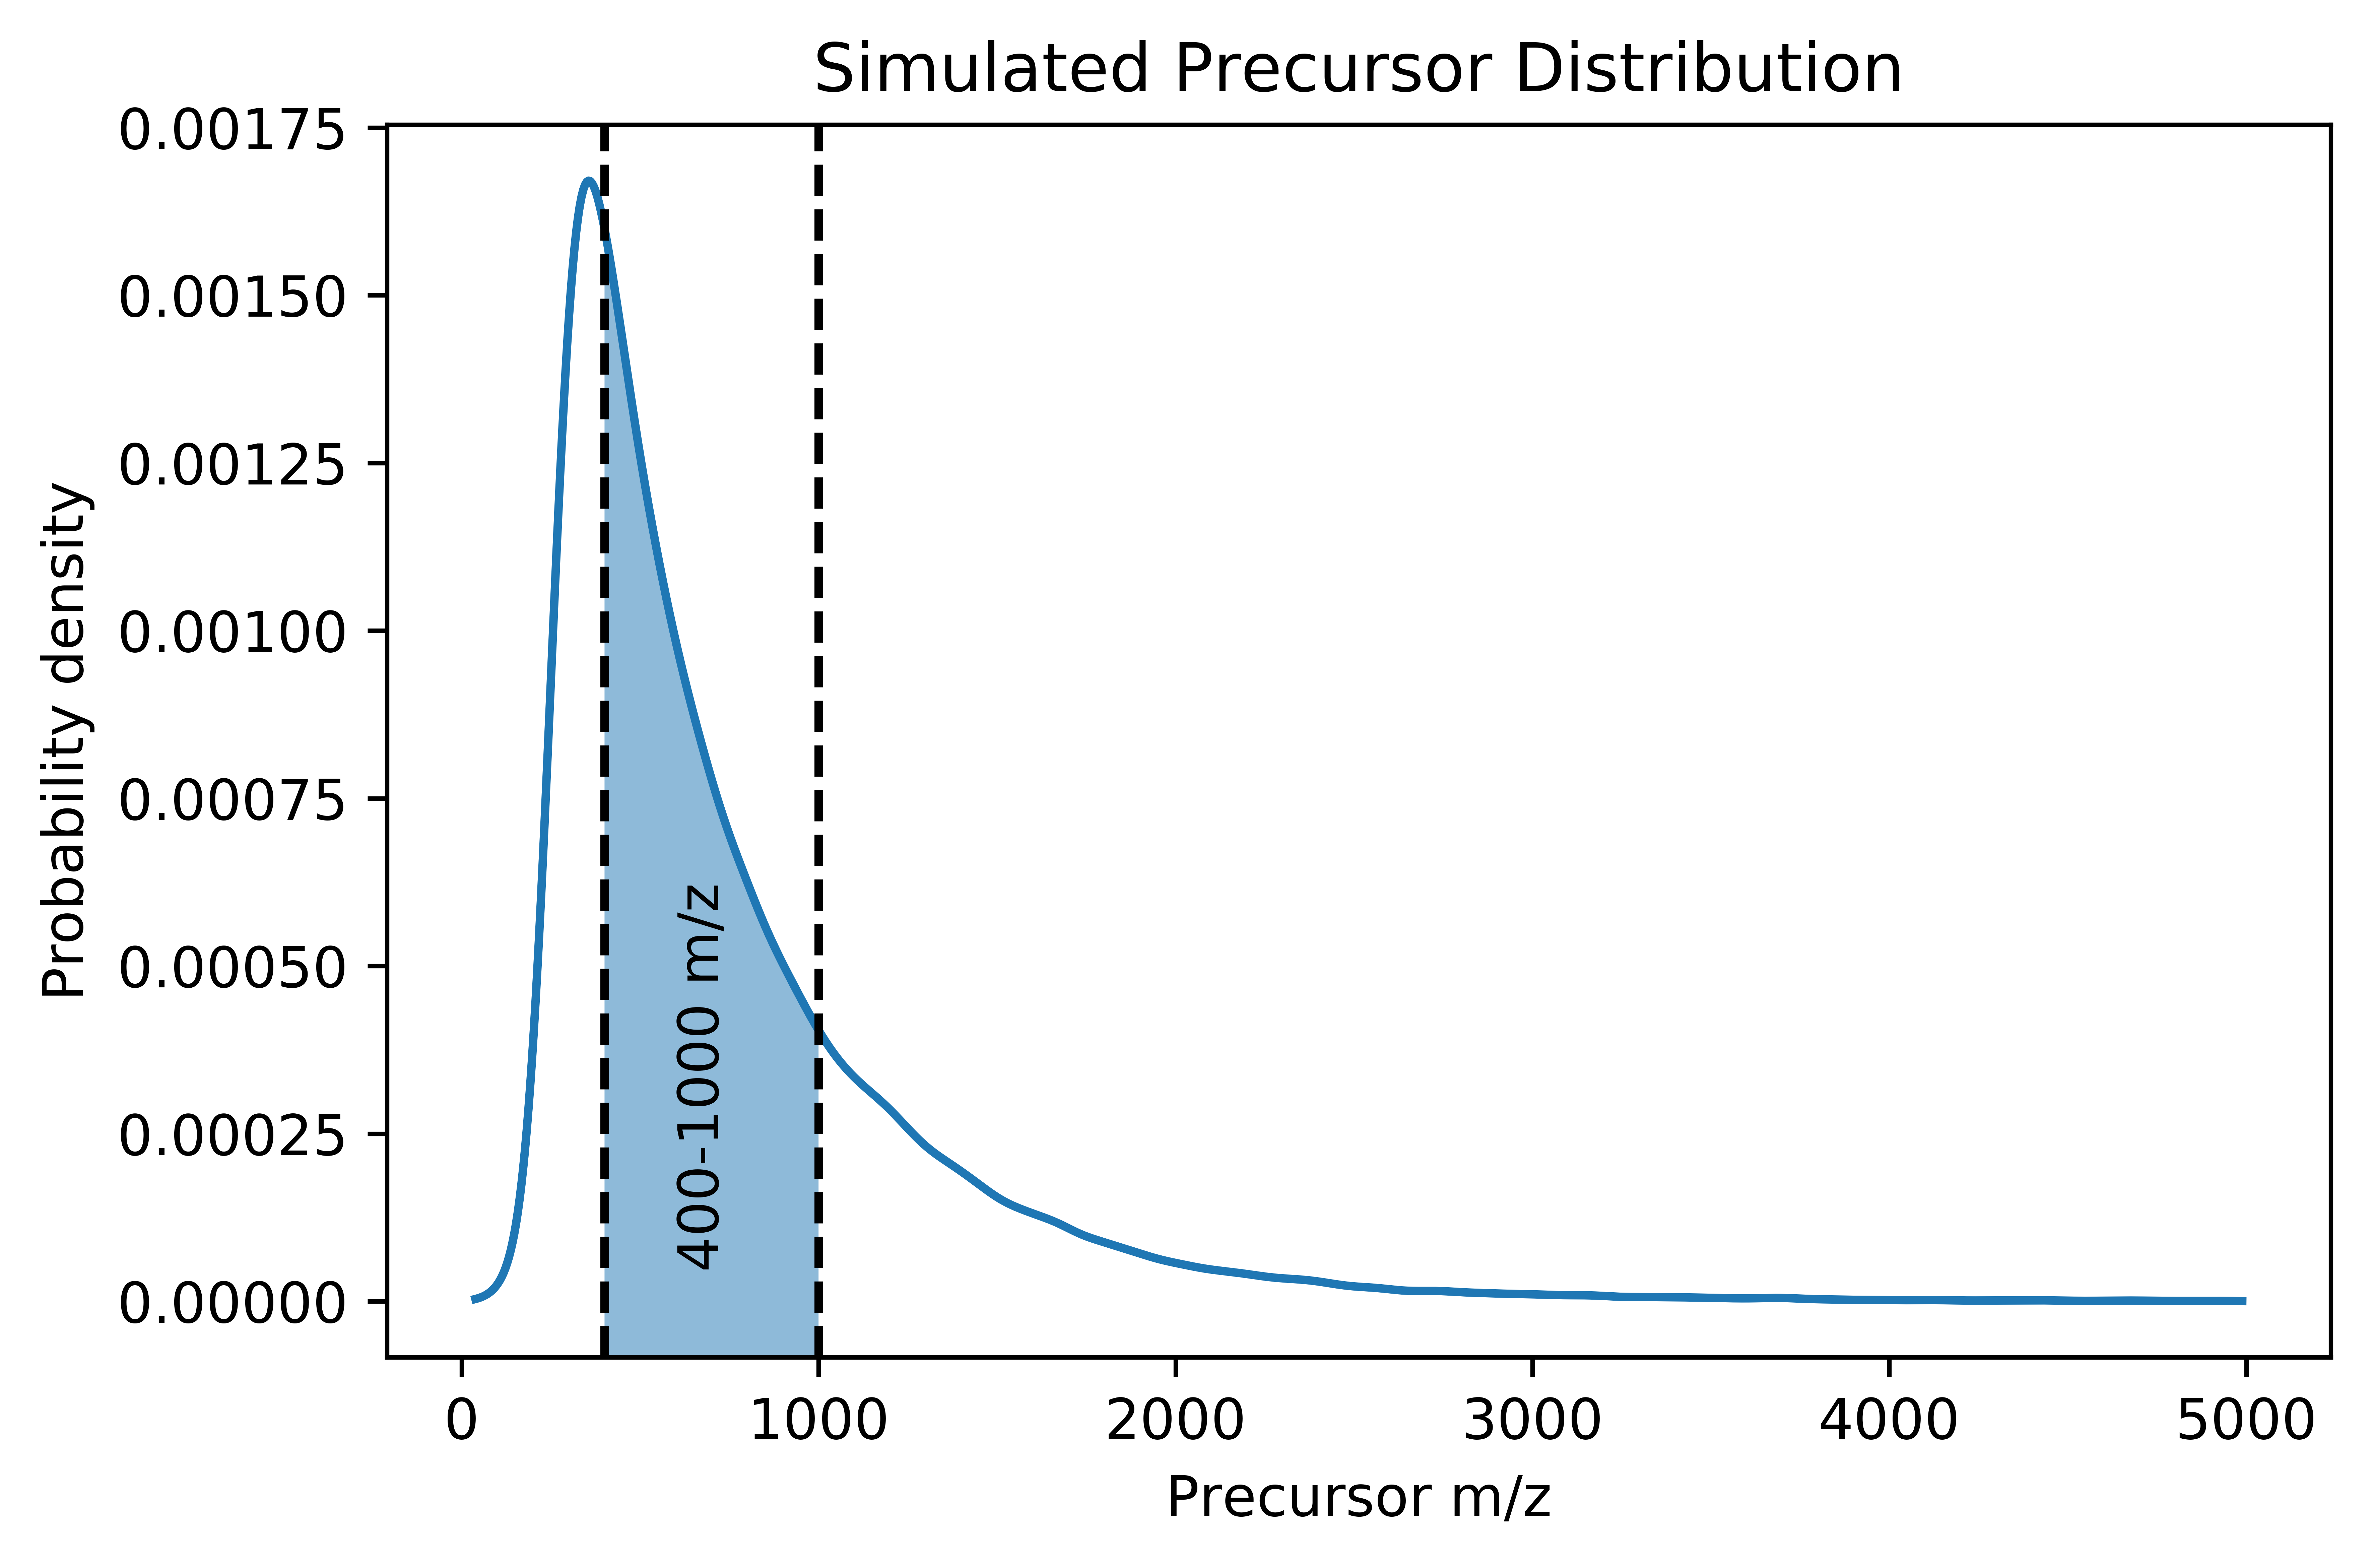

In [78]:
# Plot
plt.plot(xs, y * scale)
axes = plt.gca()
ymin, ymax = axes.get_ylim()

axes.fill_between(subset['x'], -ymax, subset['y'], alpha=0.5)
axes.set_ylim(ymin, ymax)
plt.ylabel("Probability density")
plt.xlabel("Precursor m/z")
#plt.yscale('log', nonposy='clip')
plt.title(title)

plt.axvline(400.0, color='black', linestyle='--')
plt.axvline(1000.0, color='black', linestyle='--')

plt.text(600.0, ymin + 0.35 * (ymax - ymin), '400-1000 m/z', rotation=90)
fig = plt.gcf()
fig.set_dpi(1200)
fig.tight_layout()
fig.savefig("simulated_precursor_distribution.png", dpi=1200)
plt.show()

In [40]:
df = None

Using the precursor precision of 10 ppm to bin masses probably doesn't make sense since we are only looking at the MS2, and the MS2 selectivity is limited by the quad, which only gets down to 0.4 m/z. So I wonder what the precursor 10 ppm precision is used for in Skyline and EncyclopeDIA...

## Fragments

Min fragment m/z: 58.0287401873
Max fragment m/z: 77293.5016171


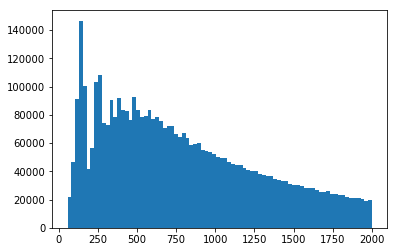

In [79]:
# Memory inefficient, oh well
all_fragments = pd.Series(np.sort(np.array(list(chain.from_iterable(g_fragments_df['MassArray'])))))
print("Min fragment m/z: {}".format(all_fragments.iloc[0]))
print("Max fragment m/z: {}".format(all_fragments.iloc[-1]))
plt.hist(all_fragments.loc[(all_fragments < 2000) & (all_fragments > 0)], bins=80)
plt.show()

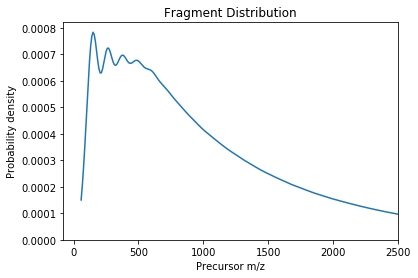

In [80]:
df = all_fragments.loc[(all_fragments <= 2800) & (all_fragments >= 0)]
plot_kde(
    df,
    title="Fragment Distribution",
    num_points=300,
    scale=(float(len(df)) / len(all_fragments))
)
axes = plt.gca()
axes.set_xlim([axes.get_xlim()[0], 2500])
plt.show()
df = None

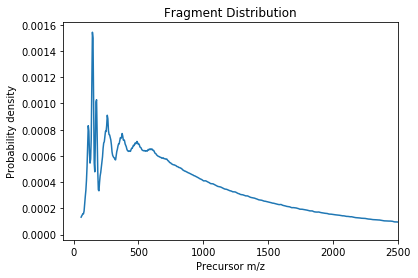

In [368]:
df = all_fragments.loc[(all_fragments <= 2800) & (all_fragments >= 0)]
plot_kde(
    df,
    bandwidth=0.01,
    title="Fragment Distribution",
    num_points=600,
    scale=(float(len(df)) / len(all_fragments))
)
axes = plt.gca()
axes.set_xlim([axes.get_xlim()[0], 2500])
plt.show()
df = None

In [83]:
# Generate data
df = all_fragments.loc[(all_fragments <= 4000) & (all_fragments >= 0)]
bandwidth=0.01
title="Simulated Fragment Distribution"
num_points=1000
scale=(float(len(df)) / len(all_fragments))
density = gaussian_kde(df, bw_method=bandwidth)
xs = np.linspace(np.min(df), np.max(df), num_points)
y = density(xs)

density_data = pd.DataFrame([])
density_data['x'] = xs
density_data['y'] = y
subset = density_data.loc[(density_data['x'] >= 200.0) & (density_data['x'] <= 1500.0)]

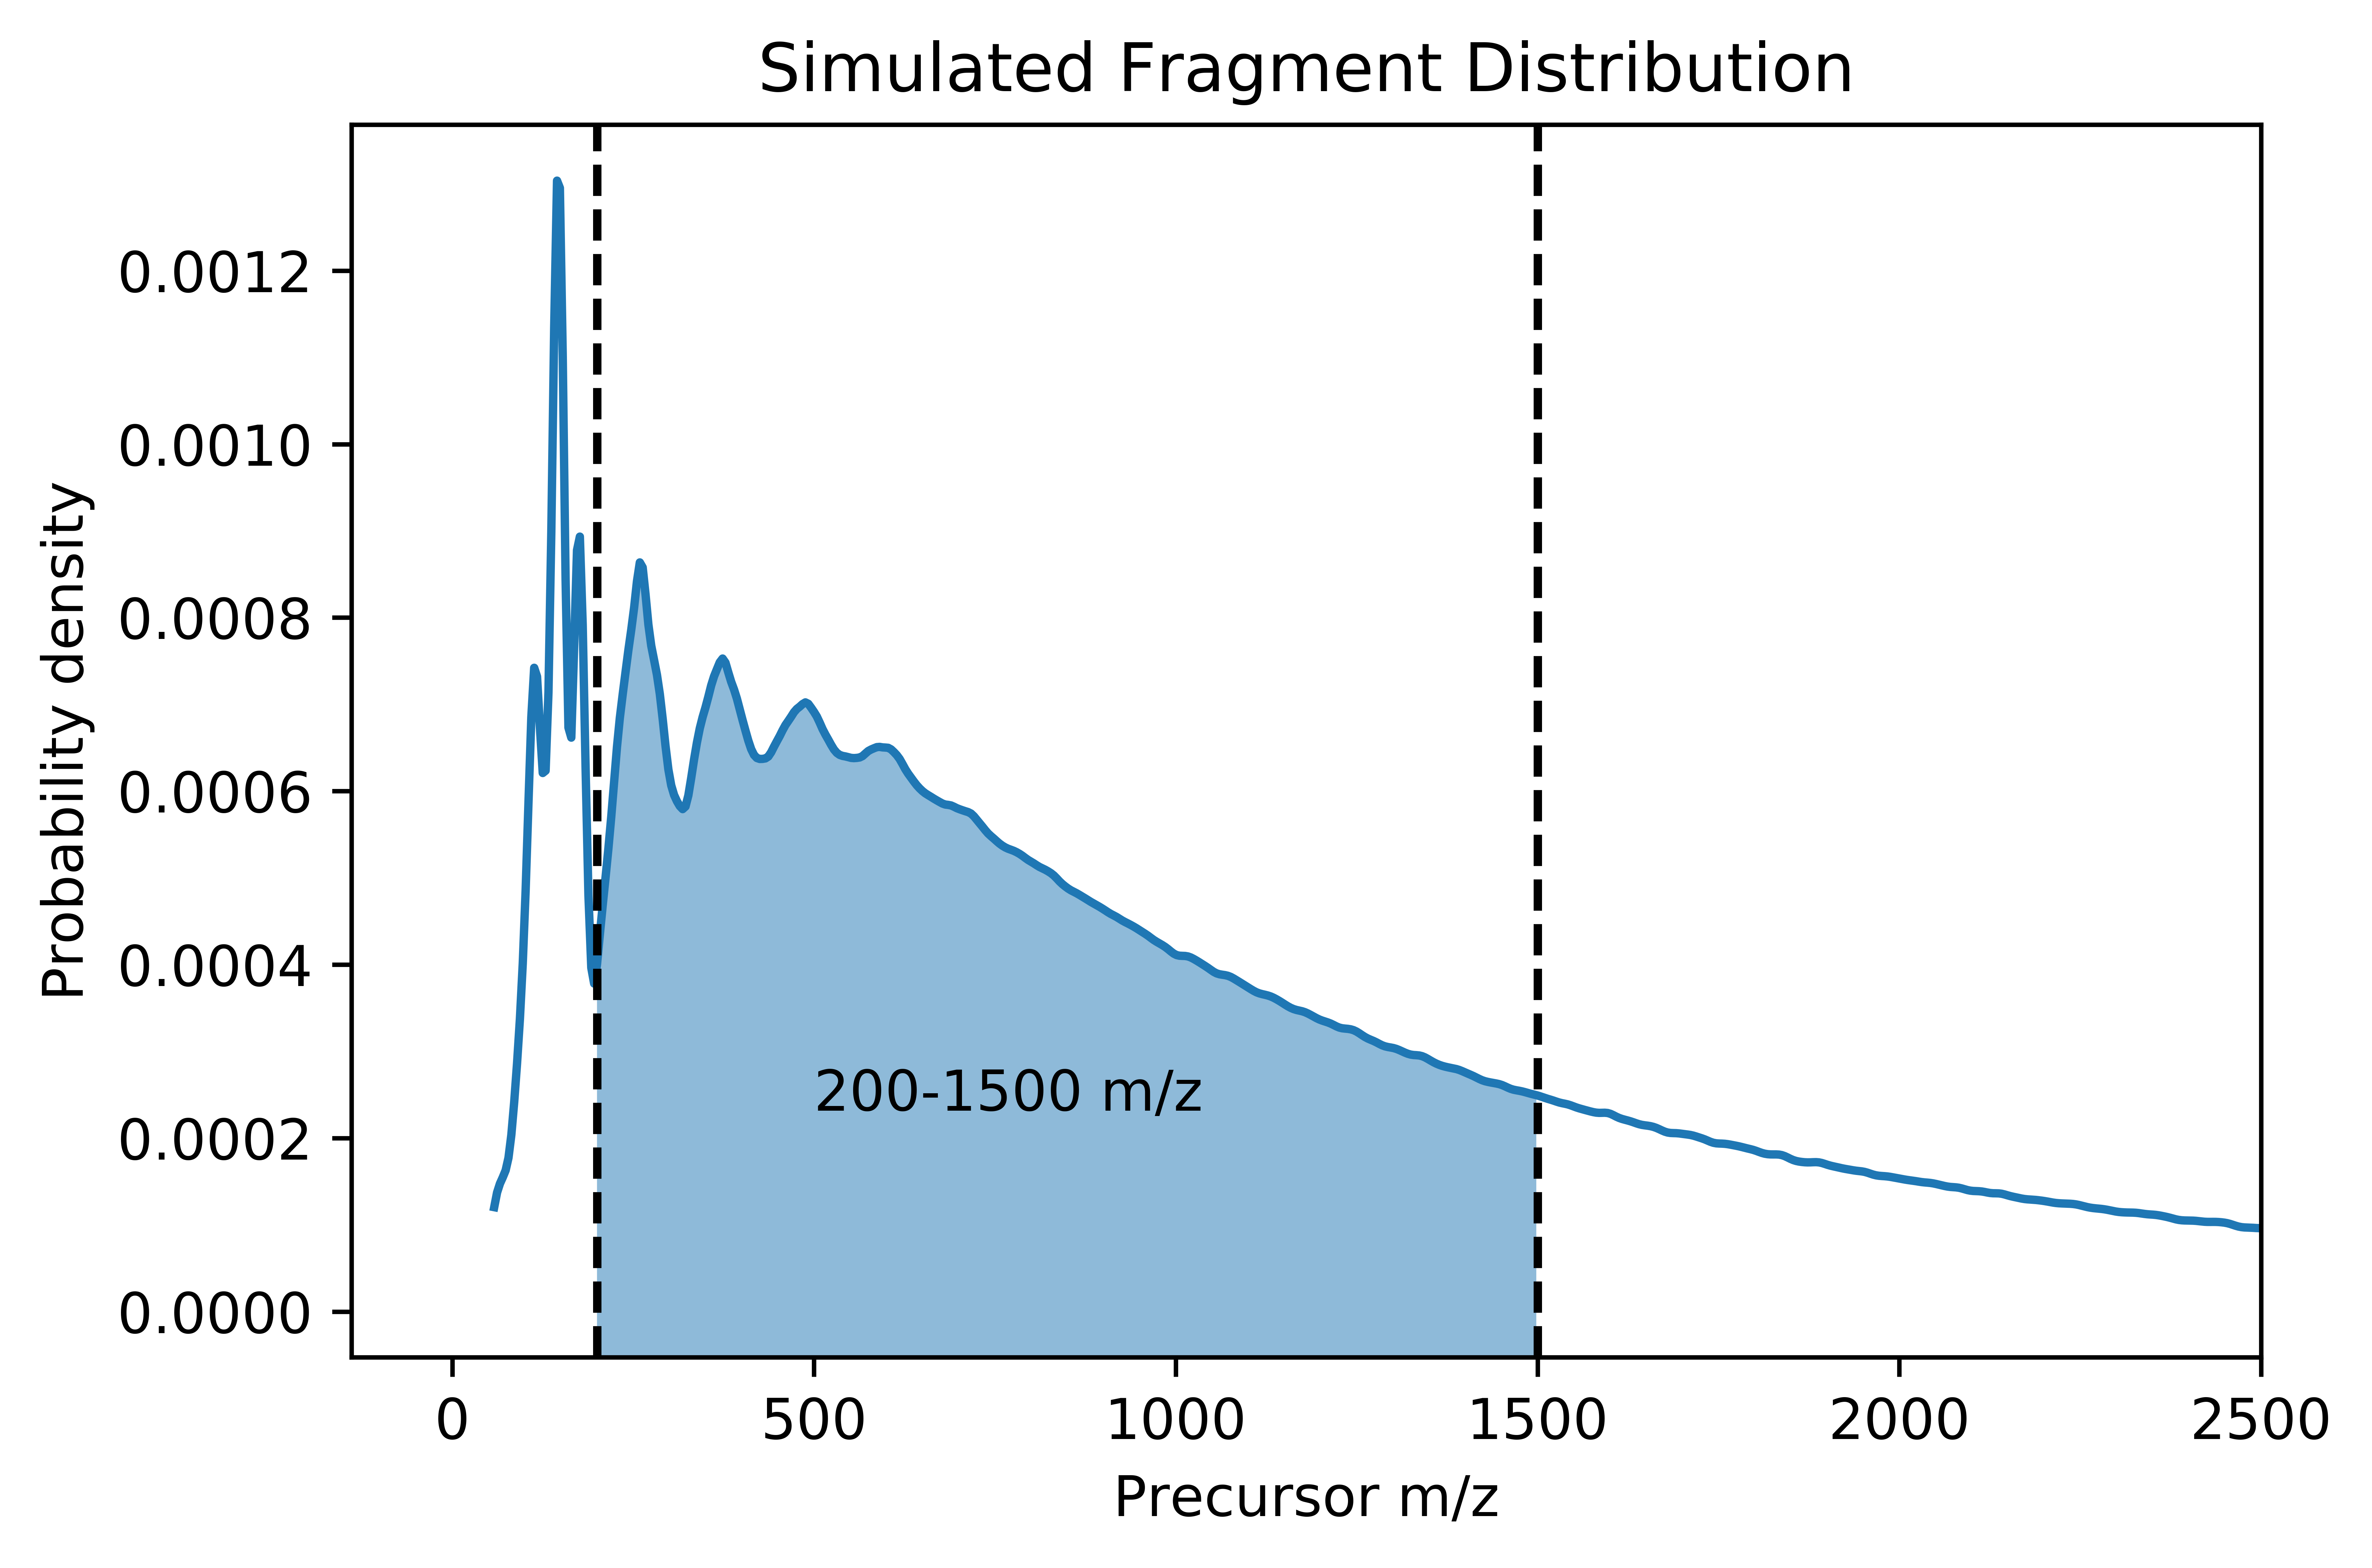

In [86]:
# Plot
plt.plot(xs, y * scale)
axes = plt.gca()
ymin, ymax = axes.get_ylim()

axes.fill_between(subset['x'], ymin - ymax, subset['y'] * scale, alpha=0.5)
axes.set_ylim(ymin, ymax)
plt.ylabel("Probability density")
plt.xlabel("Precursor m/z")
#plt.yscale('log', nonposy='clip')
plt.title(title)

plt.axvline(200.0, color='black', linestyle='--')
plt.axvline(1500.0, color='black', linestyle='--')

plt.text(500.0, ymin + 0.2 * (ymax - ymin), '200-1500 m/z', rotation=0)

axes = plt.gca()
axes.set_xlim([axes.get_xlim()[0], 2500])
fig = plt.gcf()
fig.set_dpi(1200)
fig.tight_layout()
fig.savefig("simulated_fragment_distribution.png", dpi=1200)
plt.show()
df = None

In [370]:
all_fragments = None

## Calculate the Number of Fragments per Peptide with No Interference

In [206]:
def qit_collision_factory(**kwargs):
    if 'fwhm_at_400' in kwargs.keys():
        fwhm_at_400 = kwargs['fwhm_at_400']
    elif 'resolving_power_at_400' in kwargs.keys():
        fwhm_at_400 = 400.0 / kwargs['resolving_power_at_400']
    else:
        raise Exception("Must specify one of resolving_power_at_400 or fwhm_at_400")
    
    def resolving_power(mz):
        return mz / fwhm_at_400
    
    def is_collision(mz1, mz2):
        max_mz = max(mz1, mz2)
        return abs(mz1 - mz2) * resolving_power(max_mz) / max(mz1, mz2) < 1.0
    
    return is_collision

def orbitrap_collision_factory(**kwargs):
    resolving_power_at_400 = kwargs['resolving_power_at_400']
    def resolving_power(mz):
        c = float(resolving_power_at_400) * np.sqrt(400.0)
        return c / np.sqrt(mz)
    
    def is_collision(mz1, mz2):
        max_mz = max(mz1, mz2)
        return abs(mz1 - mz2) * resolving_power(max_mz) / max(mz1, mz2) < 1.0
    
    return is_collision
      

    
collision_factories = {
    'QIT': qit_collision_factory,
    'Quad': qit_collision_factory,
    'Orbitrap': orbitrap_collision_factory
}


# Test
is_collision = qit_collision_factory(fwhm_at_400=1.0)
assert not is_collision(400.0, 401.01)
assert is_collision(400.0, 400.99)
assert not is_collision(800.0, 801.01)
assert is_collision(800.0, 800.99)

is_collision = orbitrap_collision_factory(resolving_power_at_400=100000)
assert is_collision(400.0, 400.0039)
assert not is_collision(400.0, 400.0041)

In [207]:
def qit_ms2_time(product_scan_range, resolving_power):
    """
    Calculate the theoretical time per ms2 scan. This will involve the injection time, which is a function of scan range,
    and scan time, which is a function of scan range and resolving_power.
    """
    pass

def orbitrap_ms2_time(resolving_power):
    pass

In [208]:
def table_identifier(precursor_mz_start, precursor_mz_end, precursor_width, fragment_mz_start, fragment_mz_end,
                     mass_analyzer_type, **kwargs):
    t_id = ''
    t_id += 'p' + str(precursor_mz_start) + '-' + str(precursor_mz_end) + 'at' + str(precursor_width)
    t_id += '_f' + str(fragment_mz_start) + '-' + str(fragment_mz_end)
    t_id += '_' + mass_analyzer_type
    if mass_analyzer_type == 'QIT' or mass_analyzer_type == 'Quad':
        t_id += '_' + str(kwargs['fwhm_at_400']) + 'mz'
    elif mass_analyzer_type == 'Orbitrap':
        t_id += '_' + str(kwargs['resolving_power_at_400']) + 'R'
    else:
        raise Exception('Unknown mass analyzer type ' + mass_analyzer_type)
    return t_id

In [209]:
import math

def test_table_identifer():
    # Define an experiment
    precursor_mz_start = 400.0
    precursor_mz_end = 1000.0
    fragment_mz_start = 200.0
    fragment_mz_end = 1500.0
    precursor_width = 0.7
    fragment_fwhm_at_400 = 0.7
    mass_analyzer_type = 'QIT' # QIT or Orbitrap

    print(table_identifier(precursor_mz_start, precursor_mz_end, precursor_width, fragment_mz_start, fragment_mz_end,
                           mass_analyzer_type, fwhm_at_400=fragment_fwhm_at_400))
    
test_table_identifer()

p400.0-1000.0at0.7_f200.0-1500.0_QIT_0.7mz


In [210]:
import sys


def generate_windows(precursor_mz_start, precursor_mz_end, precursor_width):
    windows = []
    for p_start in np.arange(precursor_mz_start, precursor_mz_end, precursor_width):
        windows.append((p_start, p_start + precursor_width))
    return windows

def find_interference_free_transitions(precursors_df, fragments_df, precursor_mz_start, precursor_mz_end, precursor_width, fragment_mz_start, fragment_mz_end,
                                       mass_analyzer_type, engine=None, regenerate=False, cache_results=True, **kwargs):
    # Goal should be to output number of peptides with more than a given number of transitions. We make the assumption that
    # the instrument achieves the duty cycle specified, and so are dealing with hypothetical instruments. No real-world time or
    # chromatographic constraints for now
    
    t_id = table_identifier(precursor_mz_start, precursor_mz_end, precursor_width, fragment_mz_start, fragment_mz_end,
                       mass_analyzer_type, **kwargs)
    
    # Check if the results have been calculated before
    if engine is not None and engine.dialect.has_table(engine, t_id) and not regenerate:
        return pd.read_sql_table(t_id, engine)
    
    is_collision = collision_factories[mass_analyzer_type](**kwargs)
    
    windows = generate_windows(precursor_mz_start, precursor_mz_end, precursor_width)

    # Generate flattened dataframe with precursor index and fragments
    all_fragments = np.array(list(chain.from_iterable(fragments_df['MassArray'])))
    precursor_indices = np.repeat(fragments_df.index.values, fragments_df["MassArray"].apply(len))

    # Verify that the precursor index is the same for both the fragment and precursor dataframe
    assert all(precursors_df.iloc[precursors_df.index.values]['PeptideSeq'] == fragments_df.iloc[precursors_df.index.values]['PeptideSeq'])

    transition_df = pd.DataFrame(
        {
            'PrecursorIndex': precursor_indices,
            'FragmentMz': all_fragments
        }, columns=['PrecursorIndex', 'FragmentMz'])
    all_fragments = None
    precursor_indices = None

    def rolling_has_no_interference(x):
        return not is_collision(x[0], x[1]) and (len(x) < 3 or not is_collision(x[1], x[2]))

    #isolated_frags = []
    uninterfered_frag_counts = []
    sys.stdout.write("\n")
    for i, w in enumerate(windows):
        
        sys.stdout.write("\r{0}%".format(round(100.0 * float(i + 1) / len(windows), 1)))
        # Select precursors and their corresponding fragments within this isolation window
        precursor_indices = precursors_df.loc[(precursors_df["PrecursorMz"] >= w[0]) & (precursors_df["PrecursorMz"] < w[1])].index.values
        isolated_frags_df = transition_df.loc[transition_df['PrecursorIndex'].isin(precursor_indices)].sort_values(by='FragmentMz')
        # Select fragments within the scan range
        isolated_frags_df = isolated_frags_df.loc[(isolated_frags_df['FragmentMz'] >= fragment_mz_start) & (isolated_frags_df['FragmentMz'] <= fragment_mz_end)]
        
        # Filter out fragments with interference
        uninterfered_frag_counts_df = isolated_frags_df.loc[isolated_frags_df['FragmentMz'].rolling(window=3, center=True, min_periods=2).apply(rolling_has_no_interference).astype(bool)].groupby('PrecursorIndex').count().rename(columns={'FragmentMz': 'TransitionCount'})
        uninterfered_frag_counts_df = uninterfered_frag_counts_df.merge(precursors_df, left_index=True, right_index=True)
        window_df = pd.DataFrame({
            'IsolationWindowLow': np.repeat(w[0], uninterfered_frag_counts_df.shape[0]),
            'IsolationWindowHigh': np.repeat(w[1], uninterfered_frag_counts_df.shape[0]),
        }, index=uninterfered_frag_counts_df.index.values, columns=['IsolationWindowLow', 'IsolationWindowHigh'])
        uninterfered_frag_counts_df = pd.concat([uninterfered_frag_counts_df, window_df], axis=1)
        uninterfered_frag_counts.append(uninterfered_frag_counts_df)
    uninterfered_frag_counts_df = pd.concat(uninterfered_frag_counts)
    sys.stdout.write("\n")
    
    if engine is not None:
        # Cache the results in the database
        uninterfered_frag_counts_df.to_sql(t_id, engine, if_exists='replace', index=False)
    return uninterfered_frag_counts_df

# Test
def test_find_interferences():
    kwargs = {
        'fwhm_at_400': 0.7
    }
    precursor_mz_start = 400.0
    precursor_mz_end = 1000.0
    precursor_width = 1.0
    
    mass_analyzer_type = "QIT"
    ## TODO Make dataframe with known number of interference-free transitions
    precursors_df = g_precursors_df
    fragments_df = g_fragments_df
    
    
    t_id = table_identifier(precursor_mz_start, precursor_mz_end, precursor_width, fragment_mz_start, fragment_mz_end,
                       mass_analyzer_type, **kwargs)
    
    is_collision = collision_factories[mass_analyzer_type](**kwargs)
    
    windows = generate_windows(precursor_mz_start, precursor_mz_end, precursor_width)

    # Generate flattened dataframe with precursor index and fragments
    all_fragments = np.array(list(chain.from_iterable(fragments_df['MassArray'])))
    precursor_indices = np.repeat(fragments_df.index.values, fragments_df["MassArray"].apply(len))

    # Verify that the precursor index is the same for both the fragment and precursor dataframe
    assert all(precursors_df.iloc[precursors_df.index.values]['PeptideSeq'] == fragments_df.iloc[precursors_df.index.values]['PeptideSeq'])

    transition_df = pd.DataFrame(
        {
            'PrecursorIndex': precursor_indices,
            'FragmentMz': all_fragments
        }, columns=['PrecursorIndex', 'FragmentMz'])
    all_fragments = None
    precursor_indices = None

    def rolling_has_no_interference(x):
        return not is_collision(x[0], x[1]) and (len(x) < 3 or not is_collision(x[1], x[2]))
    
    windows = generate_windows(400.0, 1000.0, 1.0)
    print(windows[0])
    i = 0
    w = windows[0]
    precursor_indices = precursors_df.loc[(precursors_df["PrecursorMz"] >= w[0]) & (precursors_df["PrecursorMz"] < w[1])].index.values
    # Select precursors and their corresponding fragments within this isolation window
    precursor_indices = precursors_df.loc[(precursors_df["PrecursorMz"] >= w[0]) & (precursors_df["PrecursorMz"] < w[1])].index.values
    isolated_frags_df = transition_df.loc[transition_df['PrecursorIndex'].isin(precursor_indices)].sort_values(by='FragmentMz')
    # Select fragments within the scan range
    isolated_frags_df = isolated_frags_df.loc[(isolated_frags_df['FragmentMz'] >= fragment_mz_start) & (isolated_frags_df['FragmentMz'] <= fragment_mz_end)]

    # Filter out fragments with interference
    uninterfered_frag_counts_df = isolated_frags_df.loc[isolated_frags_df['FragmentMz'].rolling(window=3, center=True, min_periods=2).apply(rolling_has_no_interference).astype(bool)].groupby('PrecursorIndex').count().rename(columns={'FragmentMz': 'TransitionCount'})
    uninterfered_frag_counts_df = uninterfered_frag_counts_df.merge(precursors_df, left_index=True, right_index=True)
    window_df = pd.DataFrame({
        'IsolationWindowLow': np.repeat(w[0], uninterfered_frag_counts_df.shape[0]),
        'IsolationWindowHigh': np.repeat(w[1], uninterfered_frag_counts_df.shape[0]),
    }, index=uninterfered_frag_counts_df.index.values, columns=['IsolationWindowLow', 'IsolationWindowHigh'])
    uninterfered_frag_counts_df = pd.concat([uninterfered_frag_counts_df, window_df], axis=1)
    print(uninterfered_frag_counts_df)
    
def test_find_interferences2():
    uninterfered_frag_counts_df = find_interference_free_transitions(g_precursors_df, g_fragments_df,
                                                                     precursor_mz_start, precursor_mz_end,
                                                                     fragment_mz_start=fragment_mz_start,
                                                                     fragment_mz_end=fragment_mz_end, **kwargs)
    print(uninterfered_frag_counts_df)
    
test_find_interferences()
test_find_interferences2()

(400.0, 401.0)
      TransitionCount PeptideSeq  PrecursorCharge  PrecursorMz  \
866                 6     VVQWLR                2   400.742505   
1619               10    QLLNGQK                2   400.734877   
1781               11    ISSEHVK                2   400.219060   

      IsolationWindowLow  IsolationWindowHigh  
866                400.0                401.0  
1619               400.0                401.0  
1781               400.0                401.0  

100.0%
      TransitionCount             PeptideSeq  PrecursorCharge  PrecursorMz  \
866                 6                 VVQWLR                2   400.742505   
888                 8                 ENWPQK                2   401.198128   
1592               11                LTINDVK                2   401.737086   
1619                8                QLLNGQK                2   400.734877   
1781               10                ISSEHVK                2   400.219060   
412                 8                MSNIIAR        

In [189]:
def test_find_interference_free_transitions():
    kwargs = {
        'fwhm_at_400': 0.7,
        'precursor_width': 1.0,
        'mass_analyzer_type': 'QIT'
    }
    precursor_mz_start = 400.0
    precursor_mz_end = 1000.0
    fragment_mz_start = 200.0
    fragment_mz_end = 1500.0
    
    ## TODO Make dataframe with known number of interference-free transitions
    precursors_df = g_precursors_df
    fragments_df = g_fragments_df
    
    uninterfered_frag_counts_df = find_interference_free_transitions(g_precursors_df, g_fragments_df,
                                                                     precursor_mz_start, precursor_mz_end,
                                                                     fragment_mz_start=fragment_mz_start,
                                                                     fragment_mz_end=fragment_mz_end, **kwargs)
    print(uninterfered_frag_counts_df)
    

test_find_interference_free_transitions()


100.0%
Empty DataFrame
Columns: [TransitionCount, PeptideSeq, PrecursorCharge, PrecursorMz, IsolationWindowLow, IsolationWindowHigh]
Index: []


In [ ]:
import matplotlib.ticker as ticker
from itertools import chain

runs = [
    {
        'precursor_width': 25.0,
        'resolving_power_at_400': 60000.0,
        'mass_analyzer_type': 'Orbitrap'
    },
    {
        'precursor_width': 600.0,
        'resolving_power_at_400': 60000.0,
        'mass_analyzer_type': 'Orbitrap'
    },
    {
        'precursor_width': 0.7,
        'fwhm_at_400': 0.7,
        'mass_analyzer_type': 'QIT'
    },
    {
        'precursor_width': 1.0,
        'fwhm_at_400': 1.0,
        'mass_analyzer_type': 'QIT'
    },
    {
        'precursor_width': 2.5,
        'fwhm_at_400': 1.0,
        'mass_analyzer_type': 'QIT'
    },
    {
        'precursor_width': 10.0,
        'fwhm_at_400': 1.0,
        'mass_analyzer_type': 'QIT'
    }
]
for run in runs:
    kwargs = run
    uninterfered_frag_counts_df = find_interference_free_transitions(g_precursors_df, g_fragments_df,
                                                                     precursor_mz_start, precursor_mz_end,
                                                                     fragment_mz_start=fragment_mz_start,
                                                                     fragment_mz_end=fragment_mz_end,
                                                                     engine=g_engine, **kwargs)
    mass_analyzer_type = kwargs['mass_analyzer_type']
    precursor_width = kwargs['precursor_width']
    if mass_analyzer_type == 'QIT' or mass_analyzer_type == 'Quad':
        resolution_type = 'm/z'
        resolution = kwargs['fwhm_at_400']
    elif mass_analyzer_type == 'Orbitrap':
        resolution_type = ''
        resolution = kwargs['resolving_power_at_400']
    else:
        raise Exception('Unknown mass analyzer type ' + mass_analyzer_type)
    plt.plot(xrange(1, 32), [uninterfered_frag_counts_df.loc[uninterfered_frag_counts_df['TransitionCount'] > x].shape[0] for x in xrange(0, 31)],
            label="p {}m/z / f {}{}, {}".format(precursor_width, resolution, resolution_type, mass_analyzer_type))
plt.xlabel("Number of interference-free transitions")
plt.ylabel("Number of peptides")
plt.yscale('log')
plt.legend()
axes = plt.gca()
axes.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
fig = plt.gcf()
fig.set_dpi(300.0)
plt.show()


100.0%

100.0%

100.0%

100.0%

100.0%


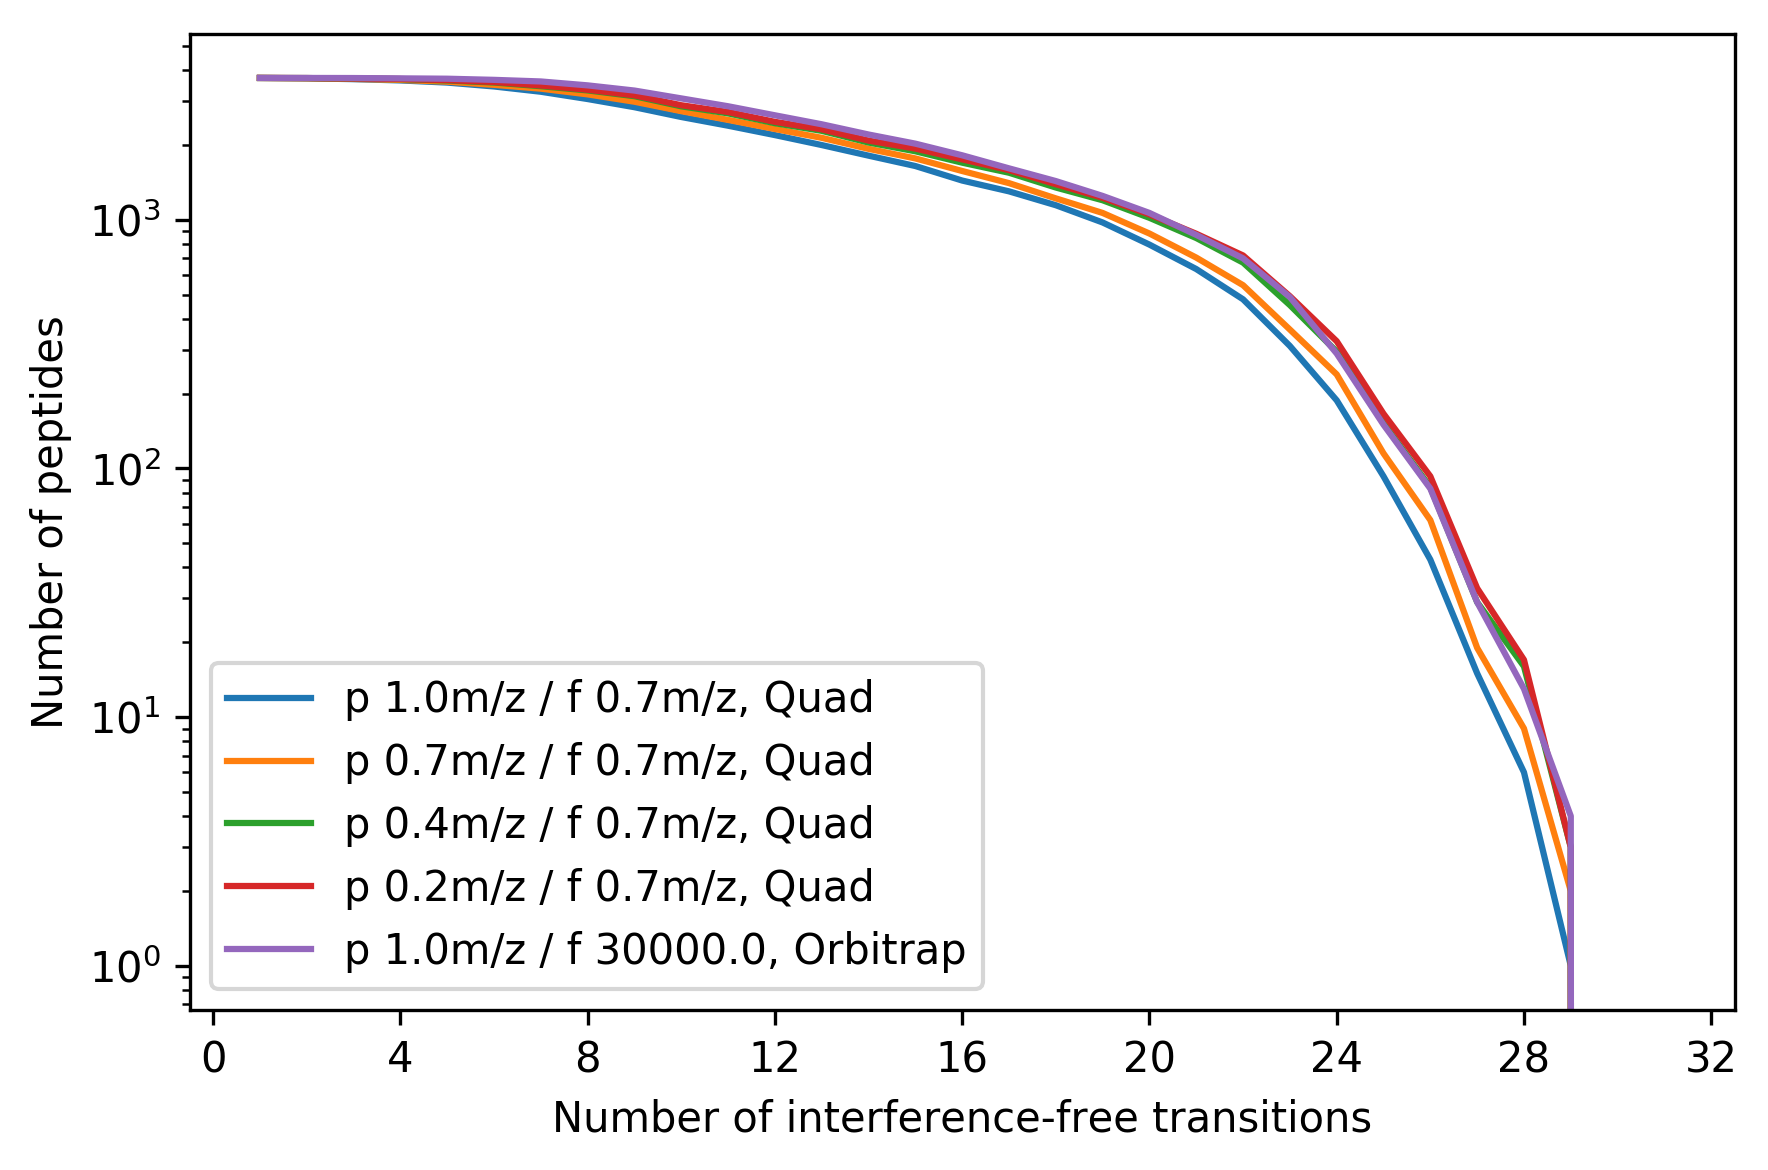

In [51]:
import matplotlib.ticker as ticker
from itertools import chain

runs = [
    {
        'precursor_width': 1.0,
        'fwhm_at_400': 0.7,
        'mass_analyzer_type': 'Quad'
    },
    {
        'precursor_width': 0.7,
        'fwhm_at_400': 0.7,
        'mass_analyzer_type': 'Quad'
    },
    {
        'precursor_width': 0.4,
        'fwhm_at_400': 0.7,
        'mass_analyzer_type': 'Quad'
    },
    {
        'precursor_width': 0.2,
        'fwhm_at_400': 0.7,
        'mass_analyzer_type': 'Quad'
    },
    {
        'precursor_width': 1.0,
        'resolving_power_at_400': 30000.0,
        'mass_analyzer_type': 'Orbitrap'
    }
]
for run in runs:
    kwargs = run
    uninterfered_frag_counts_df = find_interference_free_transitions(g_precursors_df, g_fragments_df,
                                                                     precursor_mz_start, precursor_mz_end,
                                                                     fragment_mz_start=fragment_mz_start,
                                                                     fragment_mz_end=fragment_mz_end,
                                                                     engine=g_engine, **kwargs)
    mass_analyzer_type = kwargs['mass_analyzer_type']
    precursor_width = kwargs['precursor_width']
    if mass_analyzer_type == 'QIT' or mass_analyzer_type == 'Quad':
        resolution_type = 'm/z'
        resolution = kwargs['fwhm_at_400']
    elif mass_analyzer_type == 'Orbitrap':
        resolution_type = ''
        resolution = kwargs['resolving_power_at_400']
    else:
        raise Exception('Unknown mass analyzer type ' + mass_analyzer_type)
    plt.plot(xrange(1,32), [uninterfered_frag_counts_df.loc[uninterfered_frag_counts_df['TransitionCount'] > x].shape[0] for x in xrange(0, 31)],
            label="p {}m/z / f {}{}, {}".format(precursor_width, resolution, resolution_type, mass_analyzer_type))
plt.xlabel("Number of interference-free transitions")
plt.ylabel("Number of peptides")
plt.yscale('log')
plt.legend()
axes = plt.gca()
axes.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
fig = plt.gcf()
fig.set_dpi(300.0)
fig.tight_layout()
fig.savefig("TripleQuad_Orbi_Comparison_{}.png".format(num_peptides_used), dpi=300)
plt.show()


100.0%

100.0%


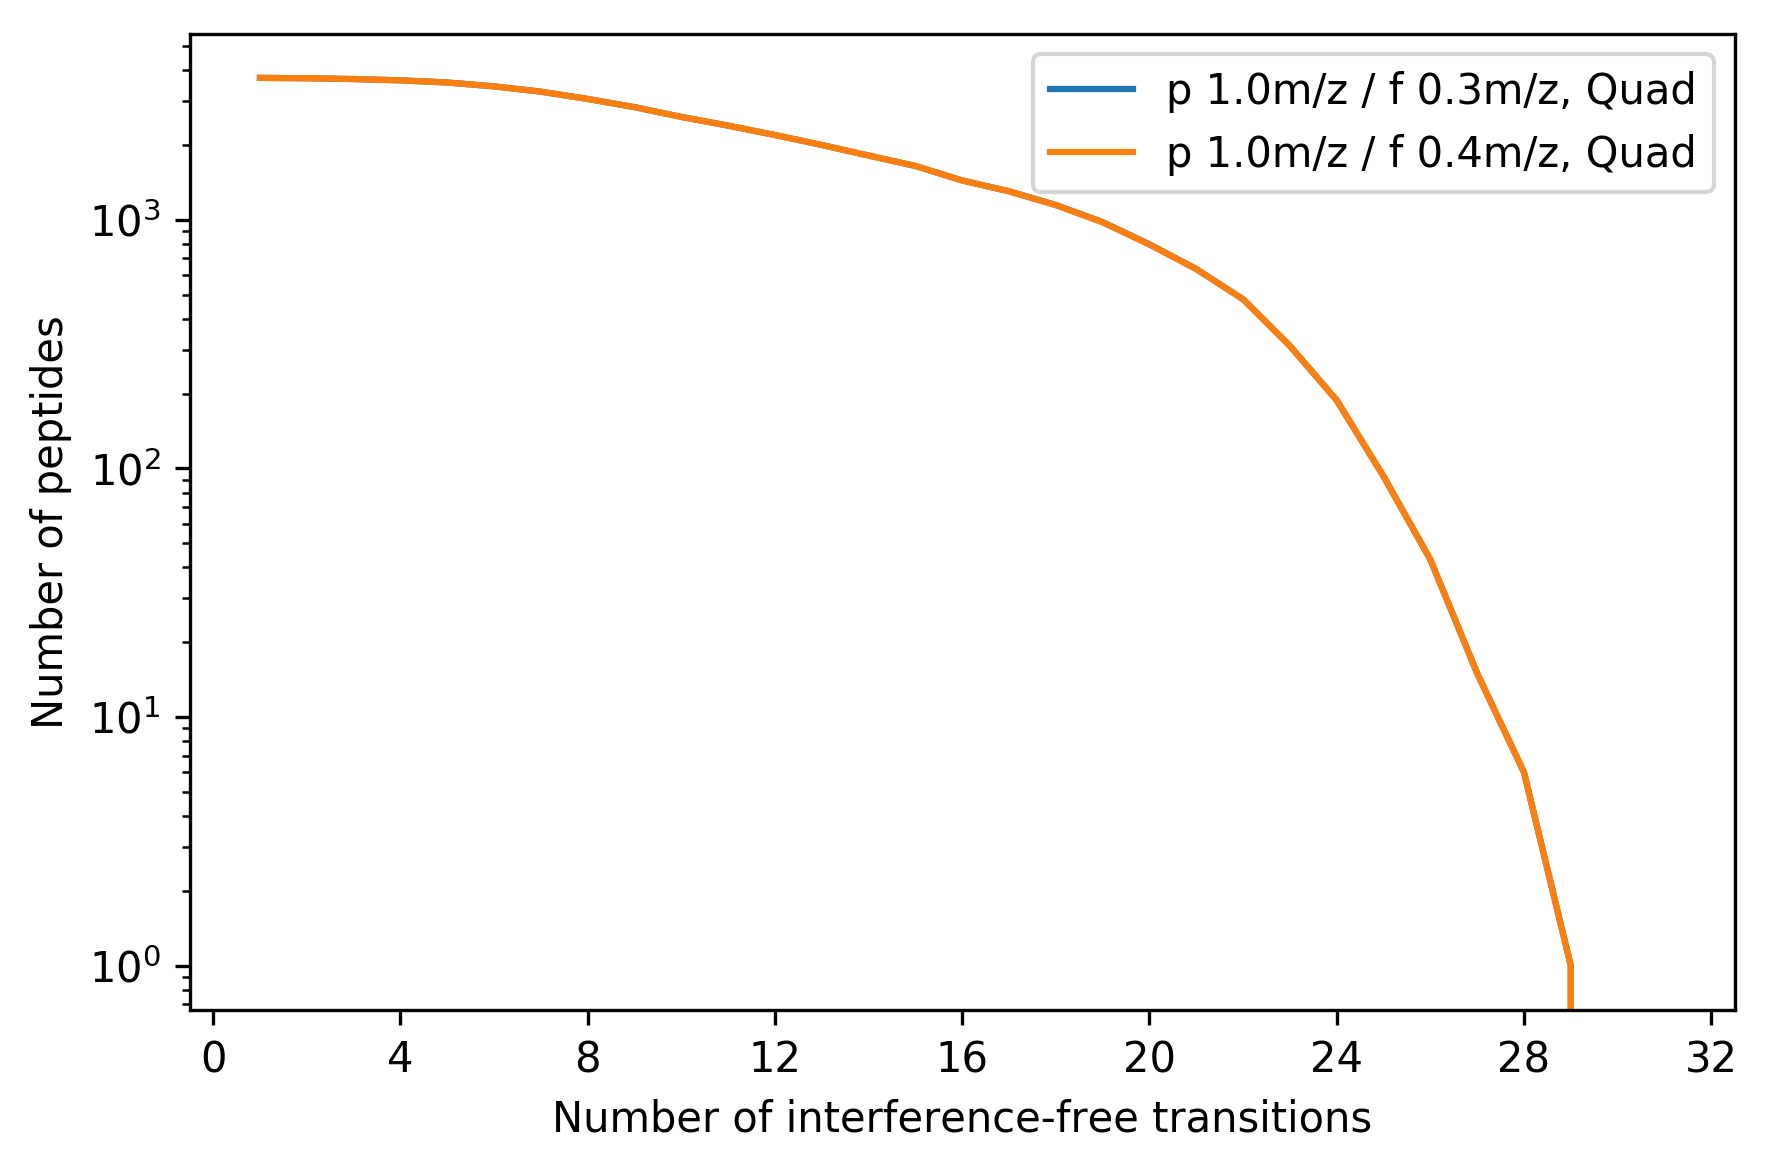

In [52]:
import matplotlib.ticker as ticker
from itertools import chain

runs = [
    {
        'precursor_width': 1.0,
        'fwhm_at_400': 0.3,
        'mass_analyzer_type': 'Quad'
    },
    {
        'precursor_width': 1.0,
        'fwhm_at_400': 0.4,
        'mass_analyzer_type': 'Quad'
    }
]
for run in runs:
    kwargs = run
    uninterfered_frag_counts_df = find_interference_free_transitions(g_precursors_df, g_fragments_df,
                                                                     precursor_mz_start, precursor_mz_end,
                                                                     fragment_mz_start=fragment_mz_start,
                                                                     fragment_mz_end=fragment_mz_end,
                                                                     engine=g_engine, regenerate=True, **kwargs)
    mass_analyzer_type = kwargs['mass_analyzer_type']
    precursor_width = kwargs['precursor_width']
    if mass_analyzer_type == 'QIT' or mass_analyzer_type == 'Quad':
        resolution_type = 'm/z'
        resolution = kwargs['fwhm_at_400']
    elif mass_analyzer_type == 'Orbitrap':
        resolution_type = ''
        resolution = kwargs['resolving_power_at_400']
    else:
        raise Exception('Unknown mass analyzer type ' + mass_analyzer_type)
    plt.plot(xrange(1,32), [uninterfered_frag_counts_df.loc[uninterfered_frag_counts_df['TransitionCount'] > x].shape[0] for x in xrange(0, 31)],
            label="p {}m/z / f {}{}, {}".format(precursor_width, resolution, resolution_type, mass_analyzer_type))
plt.xlabel("Number of interference-free transitions")
plt.ylabel("Number of peptides")
plt.yscale('log')
plt.legend()
axes = plt.gca()
axes.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
fig = plt.gcf()
fig.set_dpi(300.0)
fig.tight_layout()
fig.savefig("TripleQuad_Orbi_Comparison.png", dpi=300)
plt.show()


100.0%

100.0%

100.0%

100.0%

100.0%

100.0%


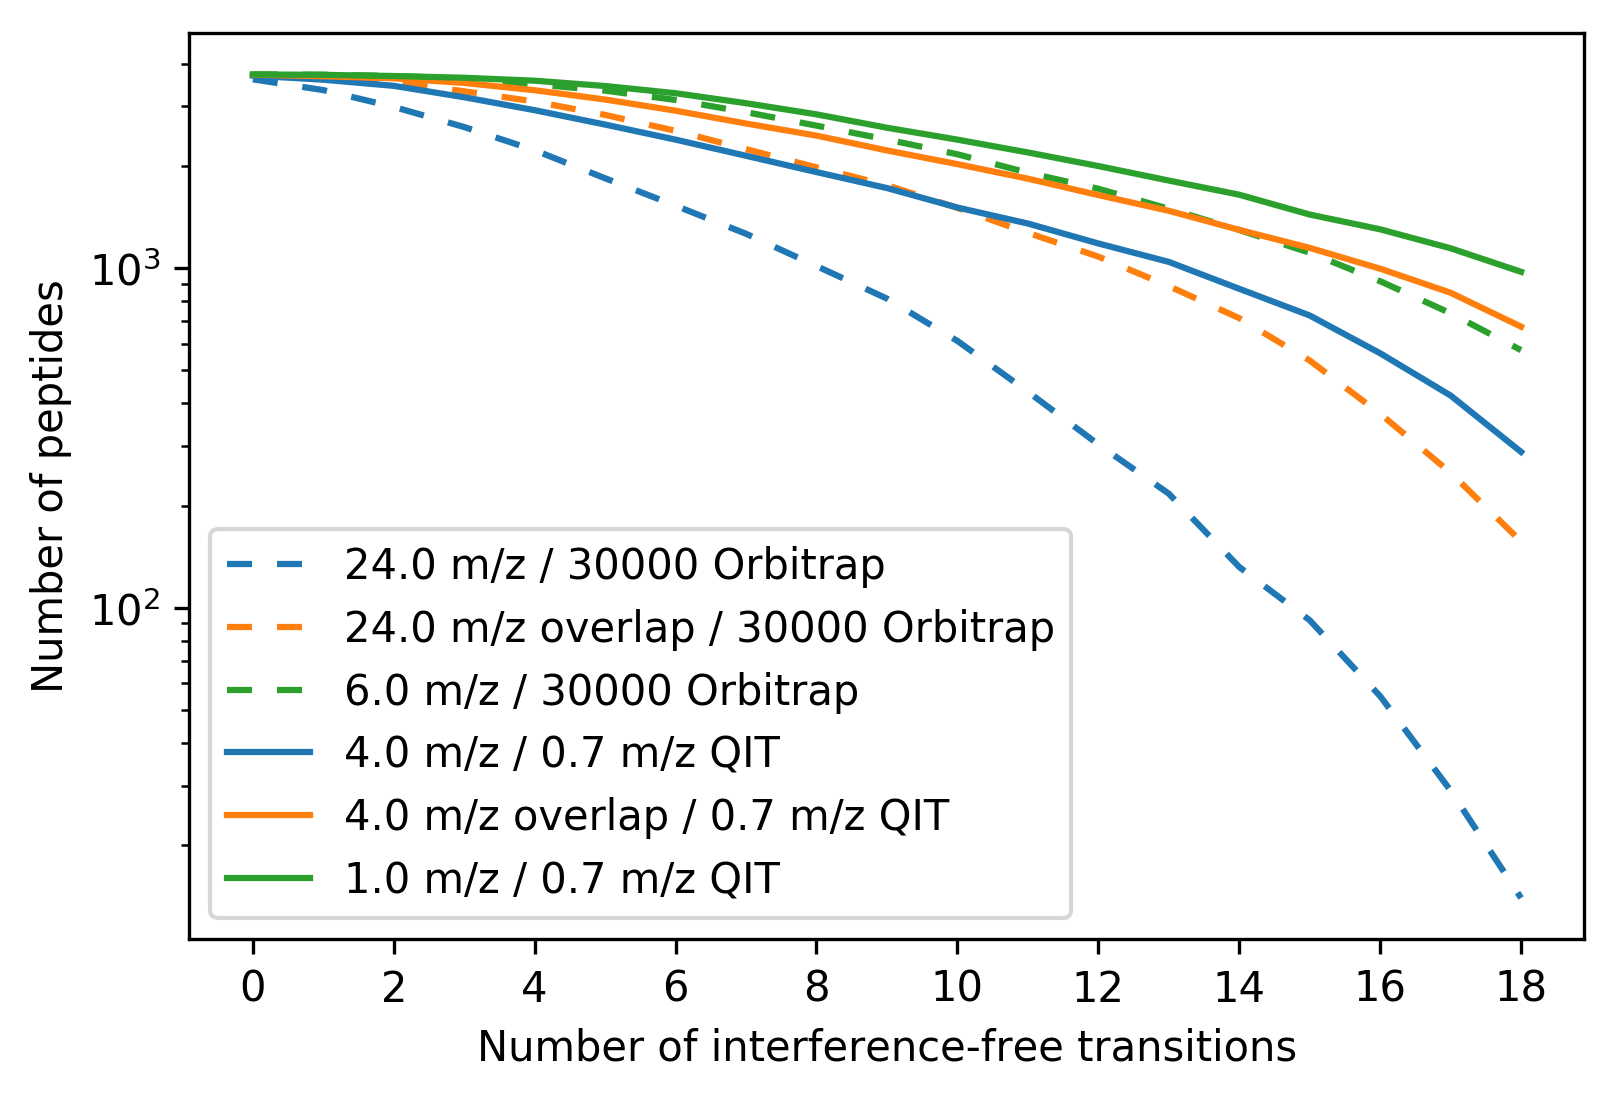

In [53]:
kwargs = {
    'precursor_width': 0.7,
    'fwhm_at_400': 0.7,
    'mass_analyzer_type': 'QIT'
}

prop_cycle = list(plt.rcParams['axes.prop_cycle'])

runs = [
    {
        'precursor_width': 24.0,
        'resolving_power_at_400': 30000.0,
        'mass_analyzer_type': 'Orbitrap',
        'style': ''
    },
    {
        'precursor_width': 12.0,
        'resolving_power_at_400': 30000.0,
        'mass_analyzer_type': 'Orbitrap',
        'style': 'overlap'
    },
    {
        'precursor_width': 6.0,
        'resolving_power_at_400': 30000.0,
        'mass_analyzer_type': 'Orbitrap',
        'style': 'library'
    },
    {
        'precursor_width': 4.0,
        'fwhm_at_400': 0.7,
        'mass_analyzer_type': 'QIT',
        'style': ''
    },
    {
        'precursor_width': 2.0,
        'fwhm_at_400': 0.7,
        'mass_analyzer_type': 'QIT',
        'style': 'overlap'
    },
    {
        'precursor_width': 1.0,
        'fwhm_at_400': 0.7,
        'mass_analyzer_type': 'QIT',
        'style': 'library'
    },
]

plotstyle = {}
for i, s in enumerate(['', 'overlap', 'library']):
    plotstyle[s] = {'color': prop_cycle[i]['color']}

m_plotstyle = {}
for i, m in enumerate(['QIT', 'Orbitrap']):
    m_plotstyle[m] = {'linestyle': '--', 'dashes': '' if i == 0 else (5 - 2*i, i * 3)}
    
for run in runs:
    kwargs = run
    plotstyle_args = plotstyle[kwargs['style']]
    for key in m_plotstyle[kwargs['mass_analyzer_type']].keys():
        plotstyle_args[key] = m_plotstyle[kwargs['mass_analyzer_type']][key]
    uninterfered_frag_counts_df = find_interference_free_transitions(g_precursors_df, g_fragments_df,
                                                                     precursor_mz_start, precursor_mz_end,
                                                                     fragment_mz_start=fragment_mz_start,
                                                                     fragment_mz_end=fragment_mz_end,
                                                                     engine=g_engine, regenerate=True,
                                                                     **kwargs)
    mass_analyzer_type = kwargs['mass_analyzer_type']
    precursor_width = kwargs['precursor_width']
    if mass_analyzer_type == 'QIT':
        resolution_type = 'm/z'
        resolution = kwargs['fwhm_at_400']
    elif mass_analyzer_type == 'Orbitrap':
        resolution_type = ''
        resolution = kwargs['resolving_power_at_400']
    else:
        raise Exception('Unknown mass analyzer type ' + mass_analyzer_type)
    label = "{} m/z{} / {}{} {}".format(precursor_width * 2 if kwargs['style'] == 'overlap' else precursor_width,
                                              ' overlap' if kwargs['style'] == 'overlap' else '',
                                              int(resolution) if mass_analyzer_type == 'Orbitrap' else resolution,
                                              ' m/z' if resolution_type == 'm/z' else '',
                                              mass_analyzer_type)
    
    x_axis = range(0, 19)
    plt.plot(x_axis, [uninterfered_frag_counts_df.loc[uninterfered_frag_counts_df['TransitionCount'] > x].shape[0] for x in x_axis],
            label=label,
            **plotstyle_args)
plt.xlabel("Number of interference-free transitions")
plt.ylabel("Number of peptides")
plt.yscale('log')
plt.legend()
axes = plt.gca()
axes.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
fig = plt.gcf()
fig.set_dpi(300.0)
fig.savefig('orbitrap_and_qit_experimental.png')
plt.show()

0.7, 1.0
0.7, 0.7
0.7, 0.4

100.0%
1.0, 1.0
1.0, 0.7
1.0, 0.4

100.0%
2.0, 1.0

100.0%
2.0, 0.7
2.0, 0.4

100.0%


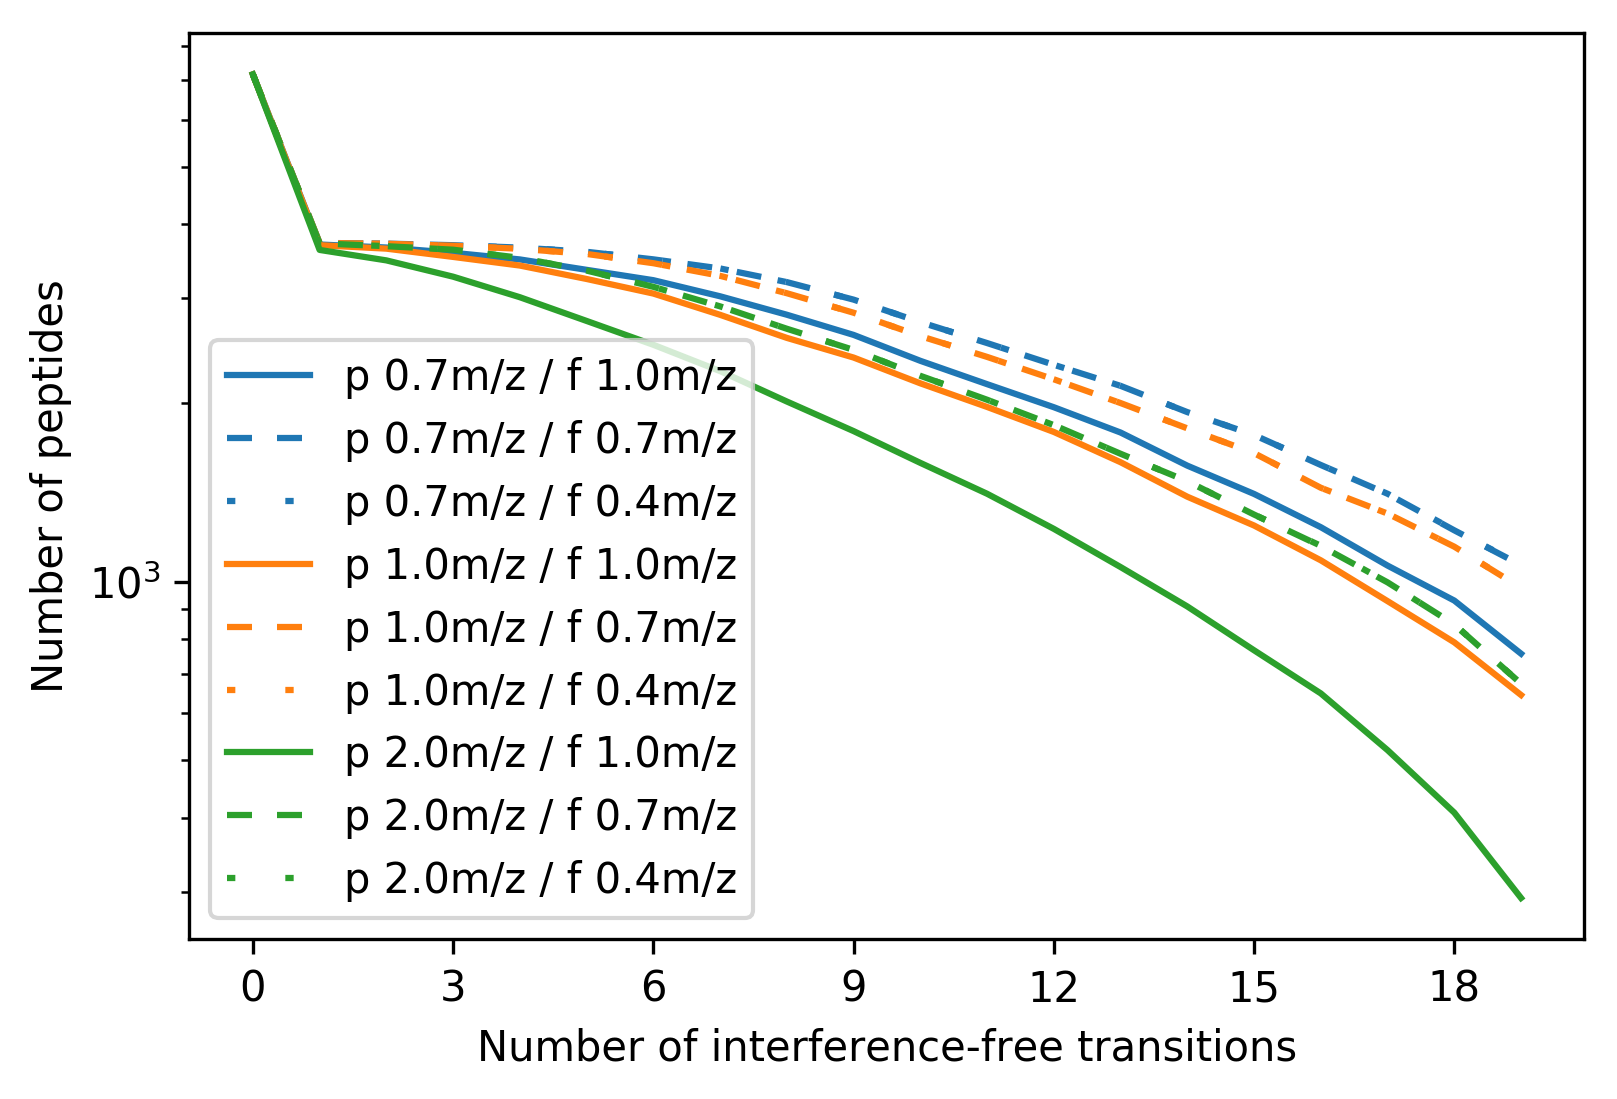

In [55]:
kwargs = {
    'precursor_width': 0.7,
    'fwhm_at_400': 0.7,
    'mass_analyzer_type': 'QIT'
}
prop_cycle = list(plt.rcParams['axes.prop_cycle'])

p_range = [0.7, 1.0, 2.0]
f_range = [1.0, 0.7, 0.4]

p_plotstyle = {}
for i, p in enumerate(p_range):
    p_plotstyle[p] = {'color': prop_cycle[i]['color']}
    
f_plotstyle = {}
for i, f in enumerate(f_range):
    f_plotstyle[f] = {'linestyle': '--', 'dashes': '' if i == 0 else (5 - 2*i, i * 3)}
    
for p, f in itertools.product(p_range, f_range):
    print("{}, {}".format(p, f))
    kwargs['precursor_width'] = p
    kwargs['fwhm_at_400'] = f
    plotstyle_args = p_plotstyle[p]
    for key in f_plotstyle[f].keys():
        plotstyle_args[key] = f_plotstyle[f][key]
    uninterfered_frag_counts_df = find_interference_free_transitions(g_precursors_df, g_fragments_df,
                                                                     precursor_mz_start, precursor_mz_end,
                                                                     fragment_mz_start=fragment_mz_start,
                                                                     fragment_mz_end=fragment_mz_end,
                                                                     engine=g_engine, regenerate=False,
                                                                     **kwargs)
    mass_analyzer_type = kwargs['mass_analyzer_type']
    precursor_width = kwargs['precursor_width']
    if mass_analyzer_type == 'QIT':
        resolution_type = 'm/z'
        resolution = kwargs['fwhm_at_400']
    elif mass_analyzer_type == 'Orbitrap':
        resolution_type = ''
        resolution = kwargs['resolving_power_at_400']
    else:
        raise Exception('Unknown mass analyzer type ' + mass_analyzer_type)
    data = [g_precursors_df.shape[0]] + [uninterfered_frag_counts_df.loc[uninterfered_frag_counts_df['TransitionCount'] > x].shape[0] for x in xrange(0, 19)]
    plt.plot(data,
            label="p {}m/z / f {}{}".format(precursor_width, resolution, resolution_type),
            **plotstyle_args)
plt.xlabel("Number of interference-free transitions")
plt.ylabel("Number of peptides")
plt.yscale('log')
#plt.title('{}'.format(mass_analyzer_type))
plt.legend()
axes = plt.gca()
axes.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
fig = plt.gcf()
fig.set_dpi(300.0)
plt.show()

In [ ]:
kwargs = {
    'mass_analyzer_type': 'Orbitrap'
}
prop_cycle = list(plt.rcParams['axes.prop_cycle'])

p_range = [3.0, 12.0, 24.0]
f_range = [30000.0, 60000.0]

p_plotstyle = {}
for i, p in enumerate(p_range):
    p_plotstyle[p] = {'color': prop_cycle[i]['color']}
    
f_plotstyle = {}
for i, f in enumerate(f_range):
    f_plotstyle[f] = {'linestyle': '--', 'dashes': '' if i == 0 else (5 - 2*i, i * 3)}
    
for p, f in itertools.product(p_range, f_range):
    print("{}, {}".format(p, f))
    kwargs['precursor_width'] = p
    kwargs['resolving_power_at_400'] = f
    plotstyle_args = p_plotstyle[p]
    for key in f_plotstyle[f].keys():
        plotstyle_args[key] = f_plotstyle[f][key]
    uninterfered_frag_counts_df = find_interference_free_transitions(g_precursors_df, g_fragments_df,
                                                                     precursor_mz_start, precursor_mz_end,
                                                                     fragment_mz_start=fragment_mz_start,
                                                                     fragment_mz_end=fragment_mz_end,
                                                                     engine=g_engine, regenerate=False,
                                                                     **kwargs)
    mass_analyzer_type = kwargs['mass_analyzer_type']
    precursor_width = kwargs['precursor_width']
    if mass_analyzer_type == 'QIT':
        resolution_type = 'm/z'
        resolution = kwargs['fwhm_at_400']
    elif mass_analyzer_type == 'Orbitrap':
        resolution_type = ''
        resolution = kwargs['resolving_power_at_400']
    else:
        raise Exception('Unknown mass analyzer type ' + mass_analyzer_type)
    data = [g_precursors_df.shape[0]] + [uninterfered_frag_counts_df.loc[uninterfered_frag_counts_df['TransitionCount'] > x].shape[0] for x in xrange(0, 19)]
    plt.plot(data,
            label="p {}m/z / f {}{}".format(precursor_width, resolution, resolution_type),
            **plotstyle_args)
plt.xlabel("Number of interference-free transitions")
plt.ylabel("Number of peptides")
plt.yscale('log')
plt.title('{}'.format(mass_analyzer_type))
plt.legend()
axes = plt.gca()
axes.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
fig = plt.gcf()
fig.set_dpi(300.0)
plt.show()

# Triple Quad vs Orbitrap Comparison

## Generate Plot Series for Mike


100.0%


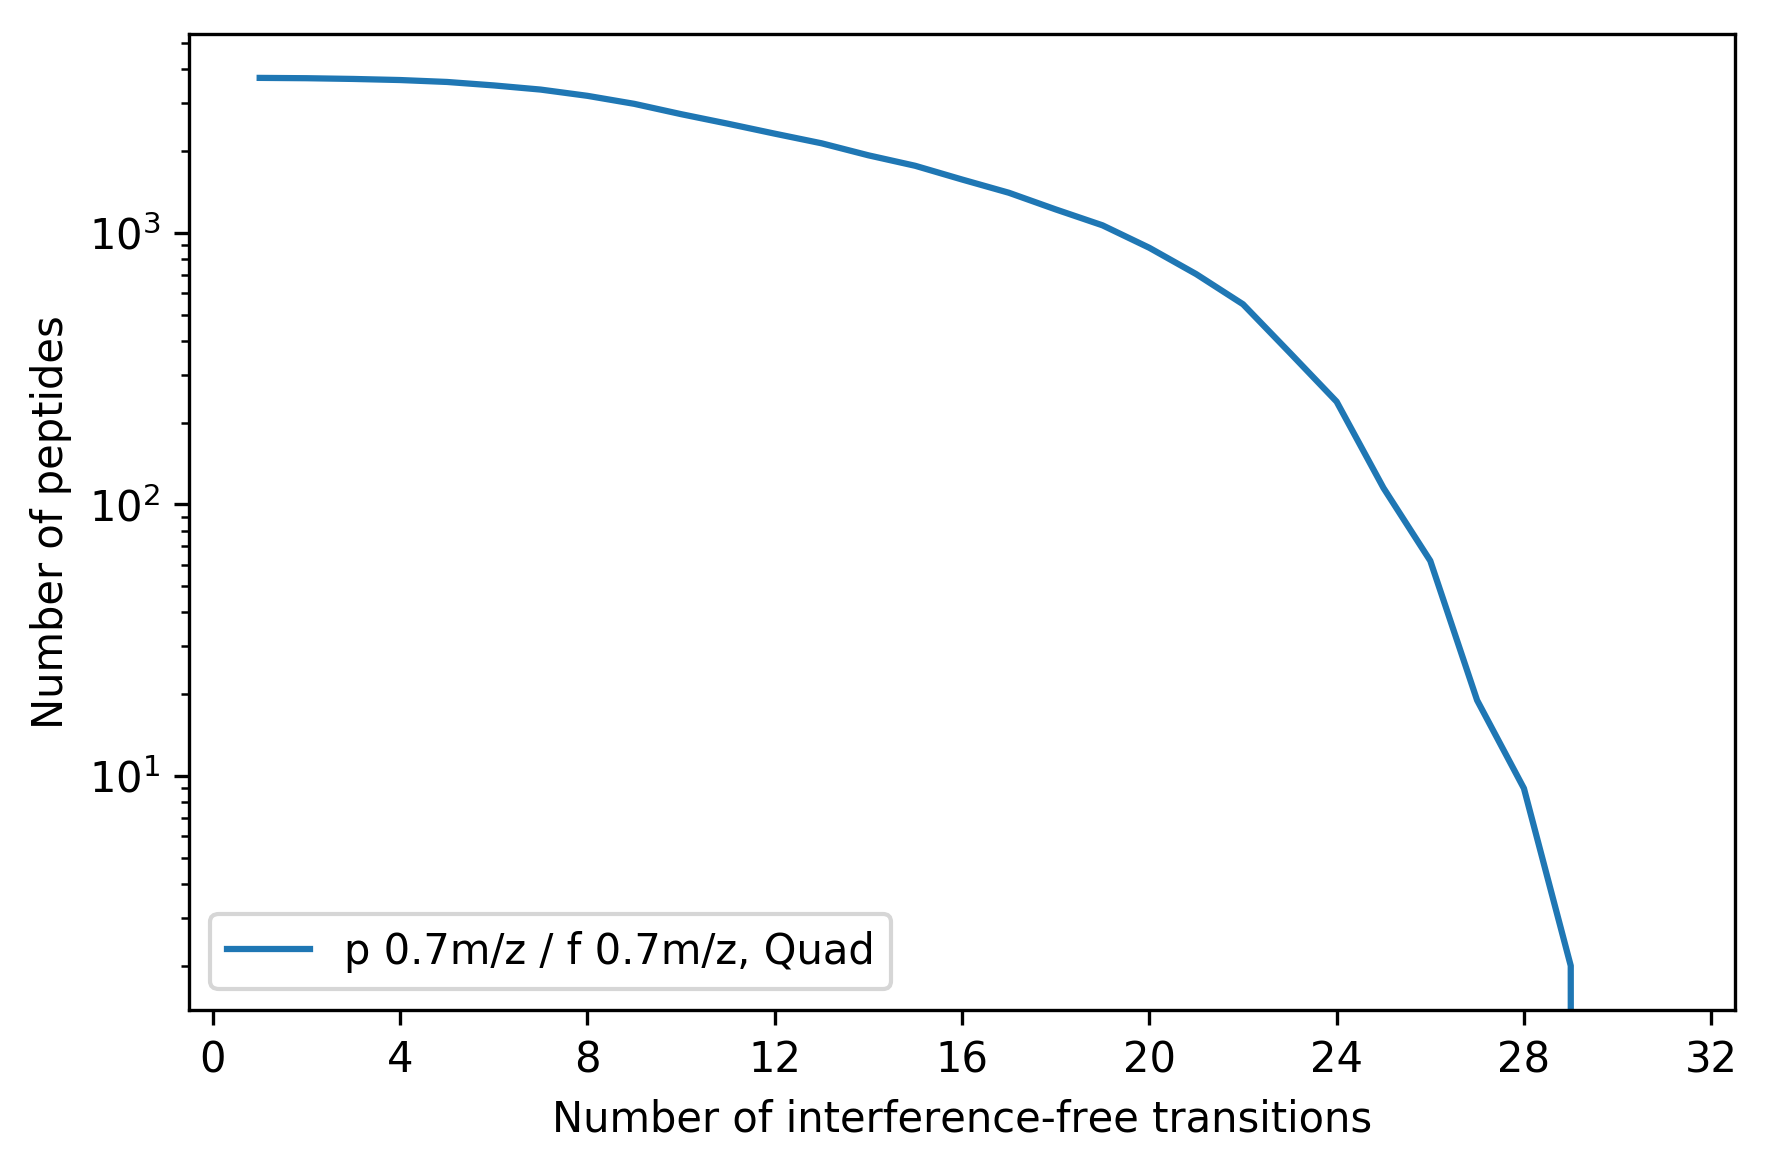


100.0%

100.0%


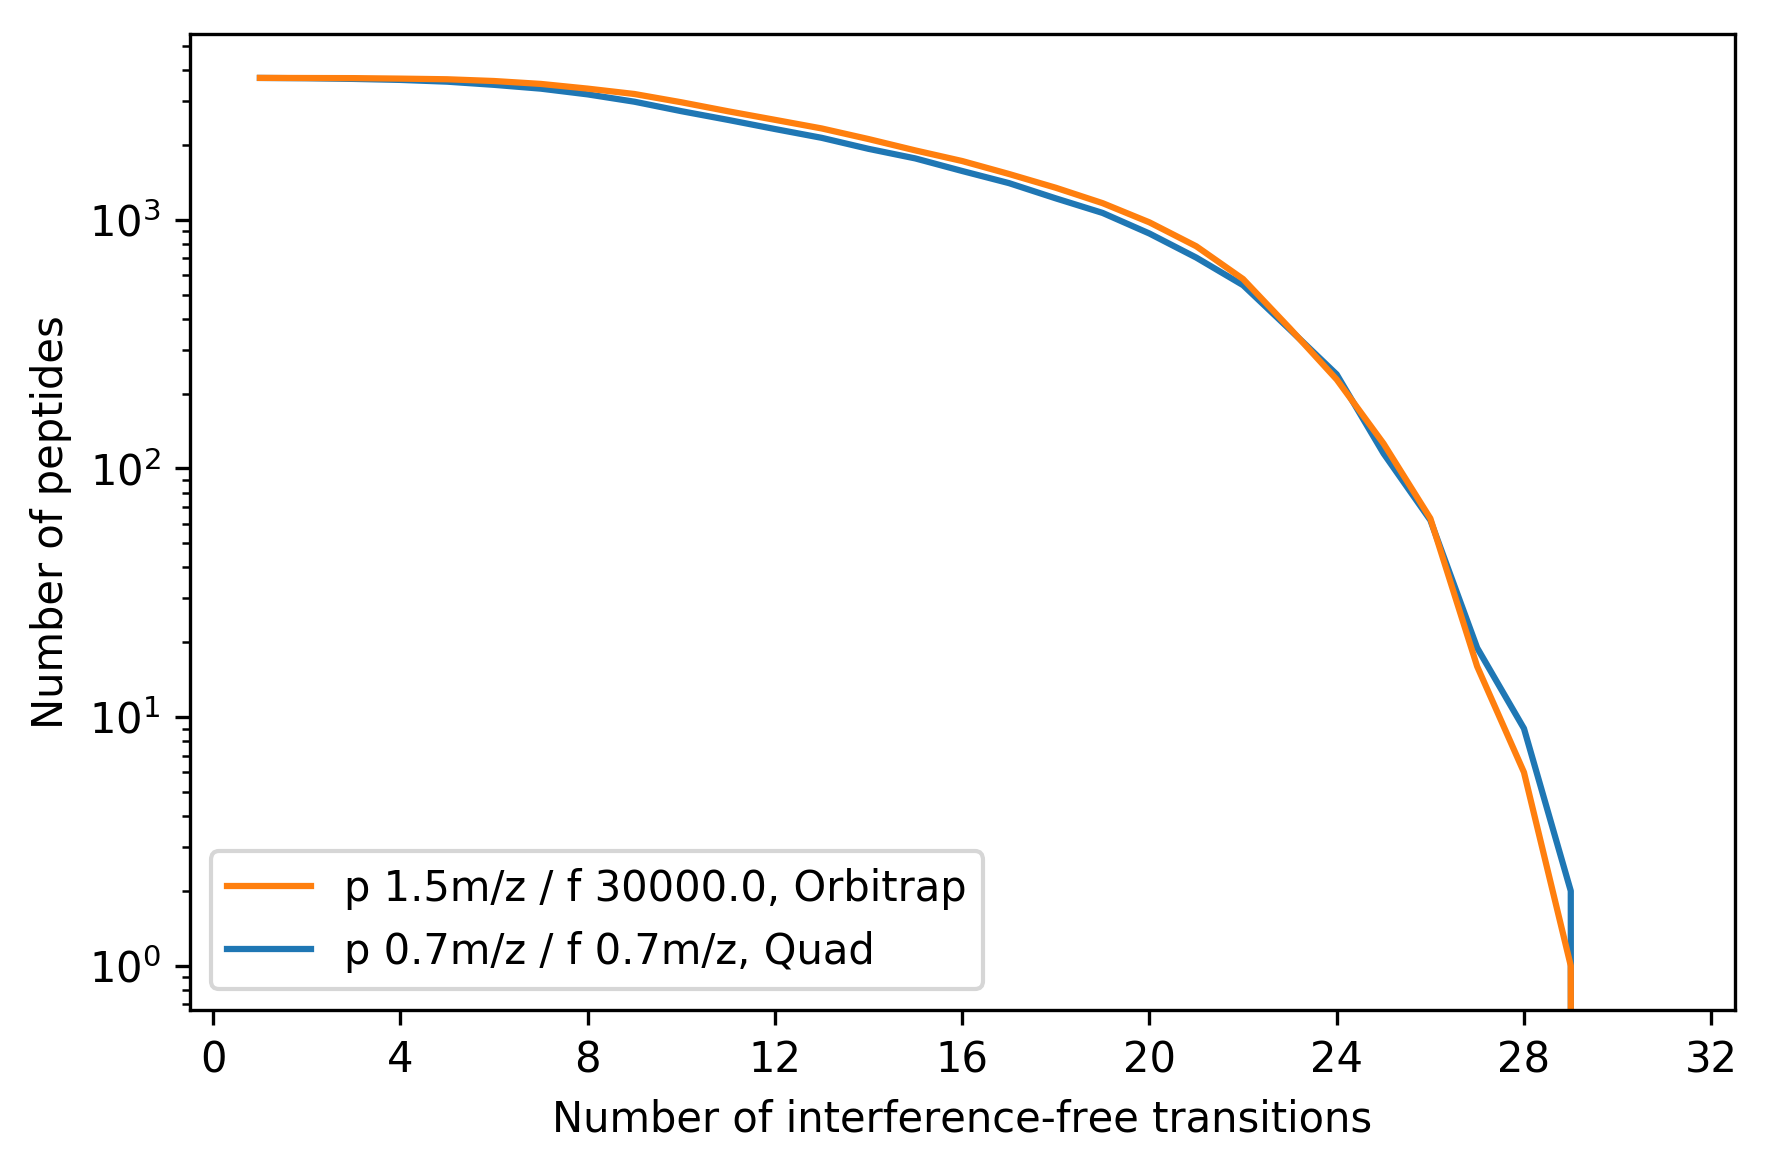


100.0%

100.0%

100.0%


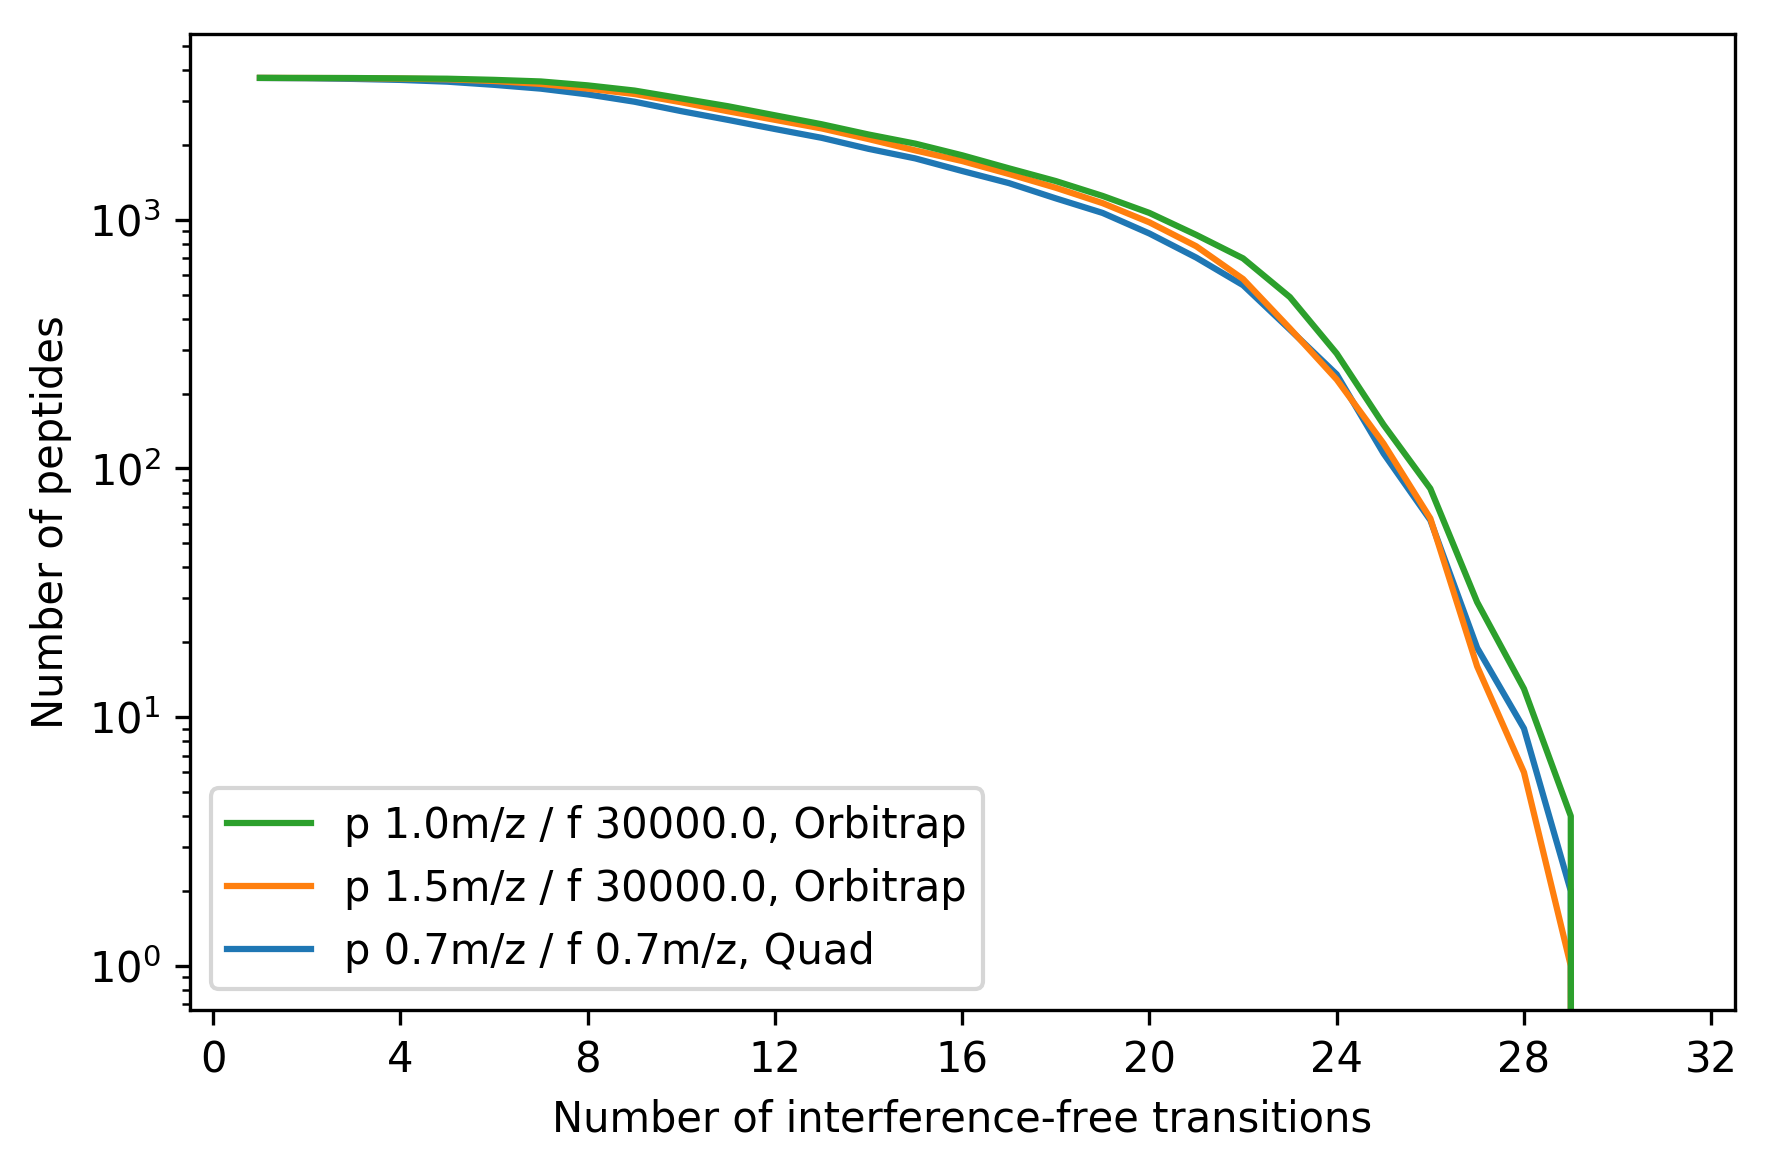


100.0%

100.0%

100.0%

100.0%


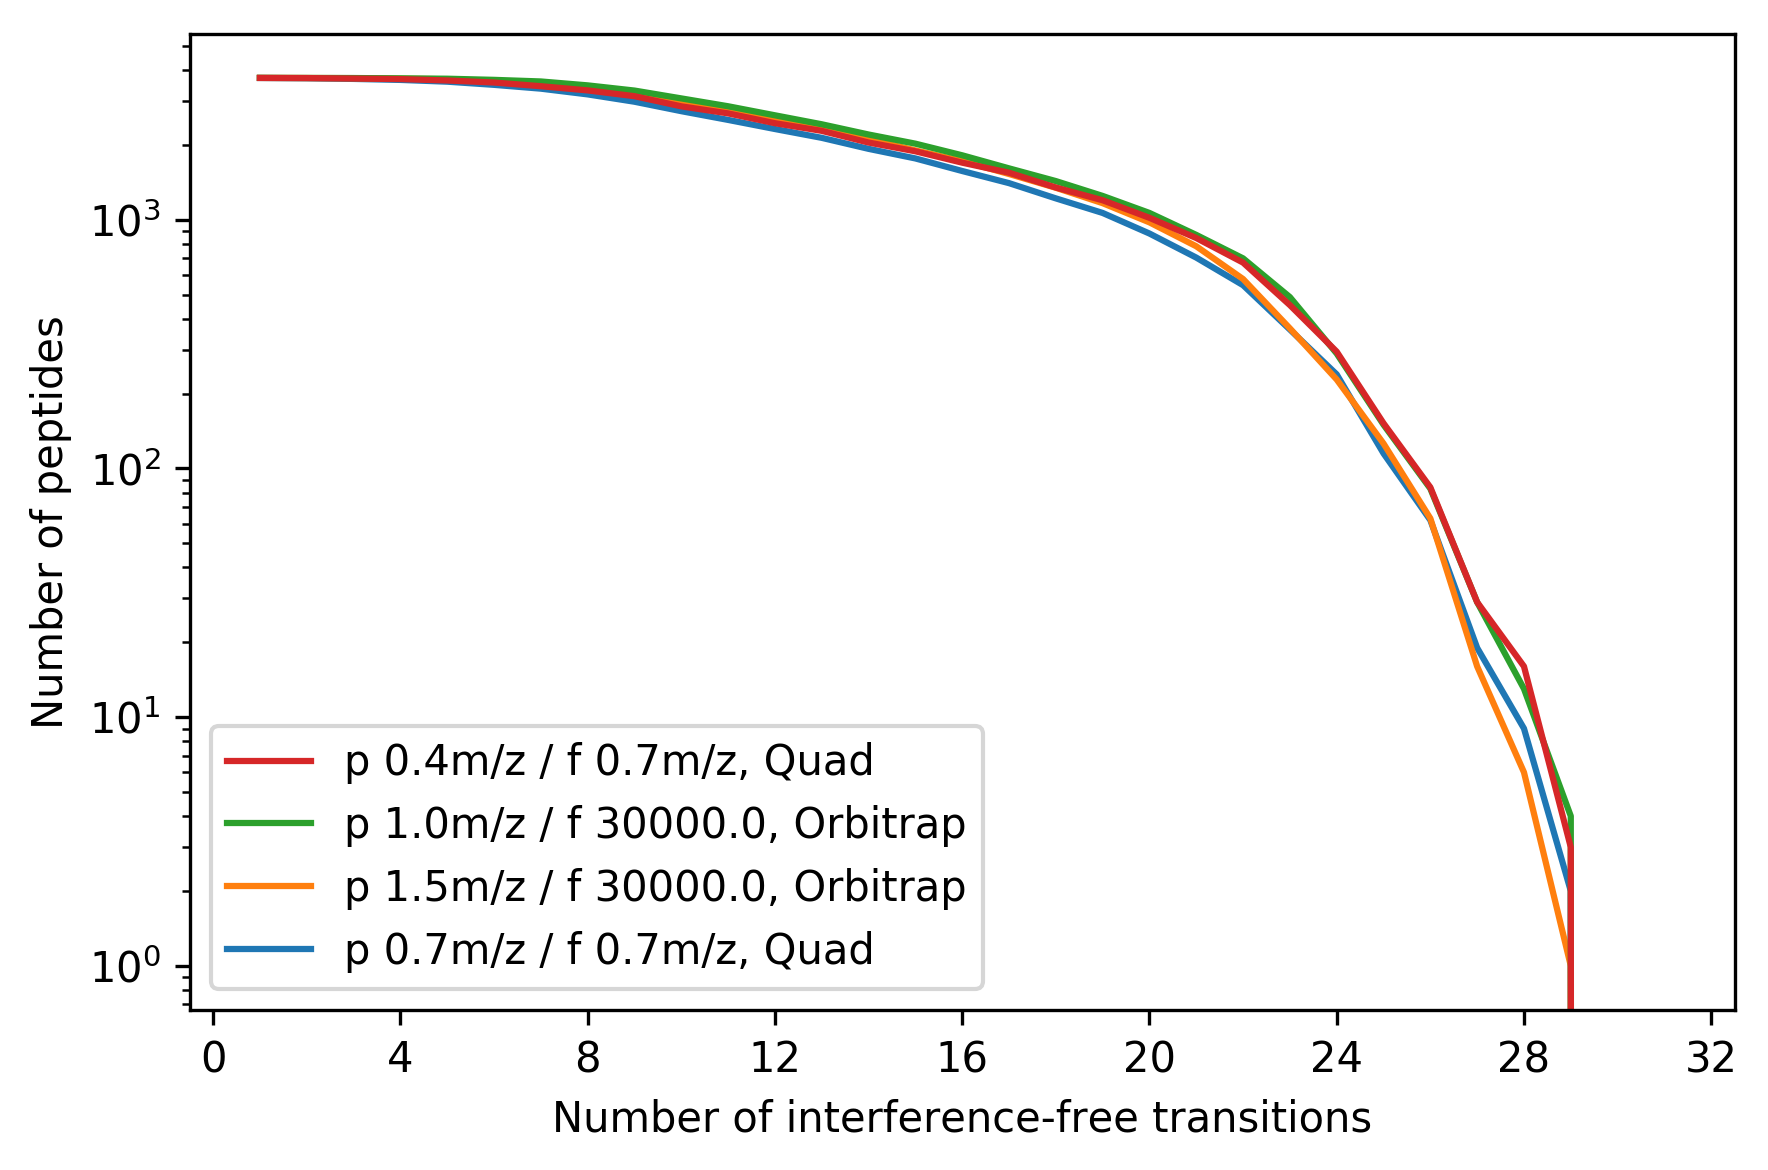


100.0%

100.0%

100.0%

100.0%

100.0%


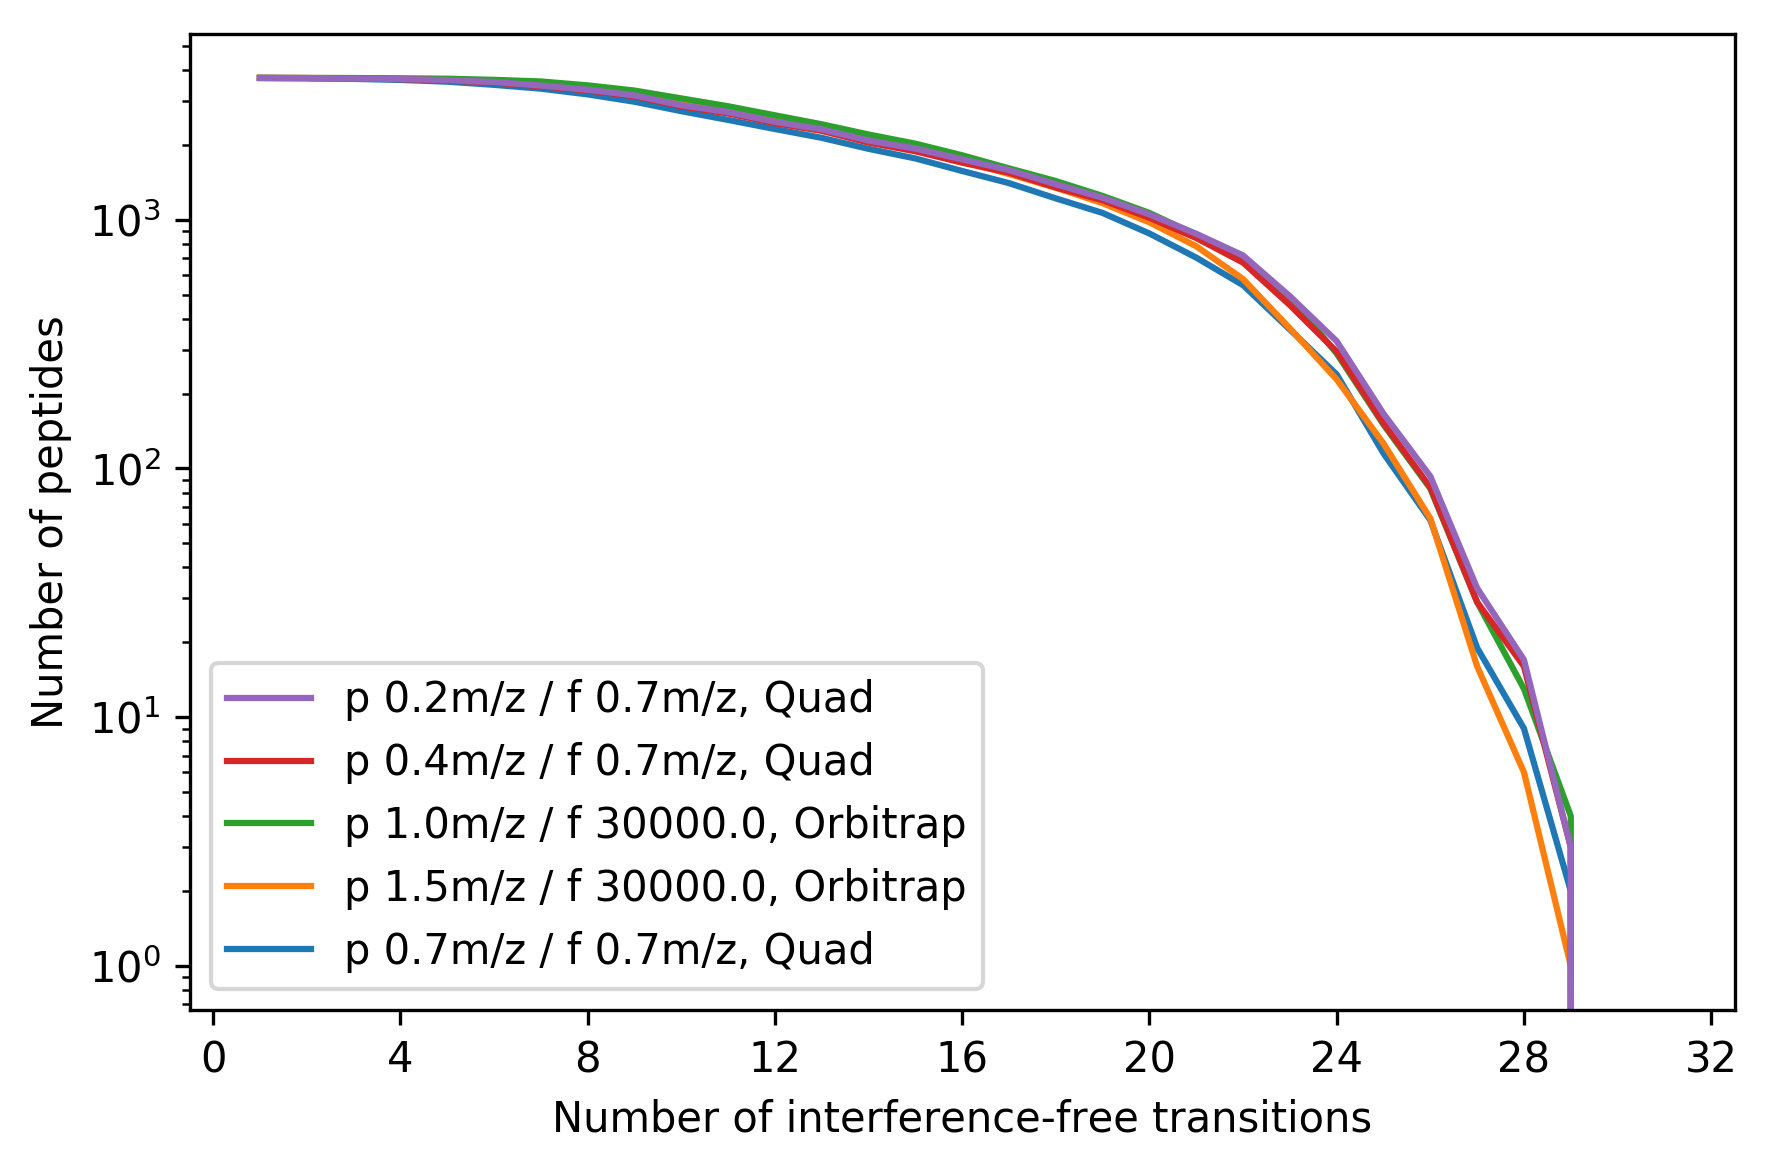

In [58]:
import matplotlib.ticker as ticker
from itertools import chain

runs_ordered = [
    {
        'precursor_width': 0.7,
        'fwhm_at_400': 0.7,
        'mass_analyzer_type': 'Quad'
    },
    {
        'precursor_width': 1.5,
        'resolving_power_at_400': 30000.0,
        'mass_analyzer_type': 'Orbitrap'
    },
    {
        'precursor_width': 1.0,
        'resolving_power_at_400': 30000.0,
        'mass_analyzer_type': 'Orbitrap'
    },
    {
        'precursor_width': 0.4,
        'fwhm_at_400': 0.7,
        'mass_analyzer_type': 'Quad'
    },
    {
        'precursor_width': 0.2,
        'fwhm_at_400': 0.7,
        'mass_analyzer_type': 'Quad'
    },
    
]

for i in range(0, len(runs_ordered)):
    runs = runs_ordered[:i + 1]
    for run in runs:
        kwargs = run
        uninterfered_frag_counts_df = find_interference_free_transitions(g_precursors_df, g_fragments_df,
                                                                         precursor_mz_start, precursor_mz_end,
                                                                         fragment_mz_start=fragment_mz_start,
                                                                         fragment_mz_end=fragment_mz_end,
                                                                         engine=g_engine, regenerate=True,
                                                                         **kwargs)
        mass_analyzer_type = kwargs['mass_analyzer_type']
        precursor_width = kwargs['precursor_width']
        if mass_analyzer_type == 'QIT' or mass_analyzer_type == 'Quad':
            resolution_type = 'm/z'
            resolution = kwargs['fwhm_at_400']
        elif mass_analyzer_type == 'Orbitrap':
            resolution_type = ''
            resolution = kwargs['resolving_power_at_400']
        else:
            raise Exception('Unknown mass analyzer type ' + mass_analyzer_type)
        plt.plot(xrange(1,32), [uninterfered_frag_counts_df.loc[uninterfered_frag_counts_df['TransitionCount'] > x].shape[0] for x in xrange(0, 31)],
                label="p {}m/z / f {}{}, {}".format(precursor_width, resolution, resolution_type, mass_analyzer_type))
    plt.xlabel("Number of interference-free transitions")
    plt.ylabel("Number of peptides")
    plt.yscale('log')
    axes = plt.gca()
    axes.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    handles, labels = axes.get_legend_handles_labels()
    axes.legend(handles[::-1], labels[::-1], loc='lower left') # reverse legend order
    fig = plt.gcf()
    fig.set_dpi(300.0)
    fig.tight_layout()
    fig.savefig("TripleQuad_Orbi_Comparison_{}.png".format(i), dpi=300)
    plt.show()

## Low vs High Mass Fragments

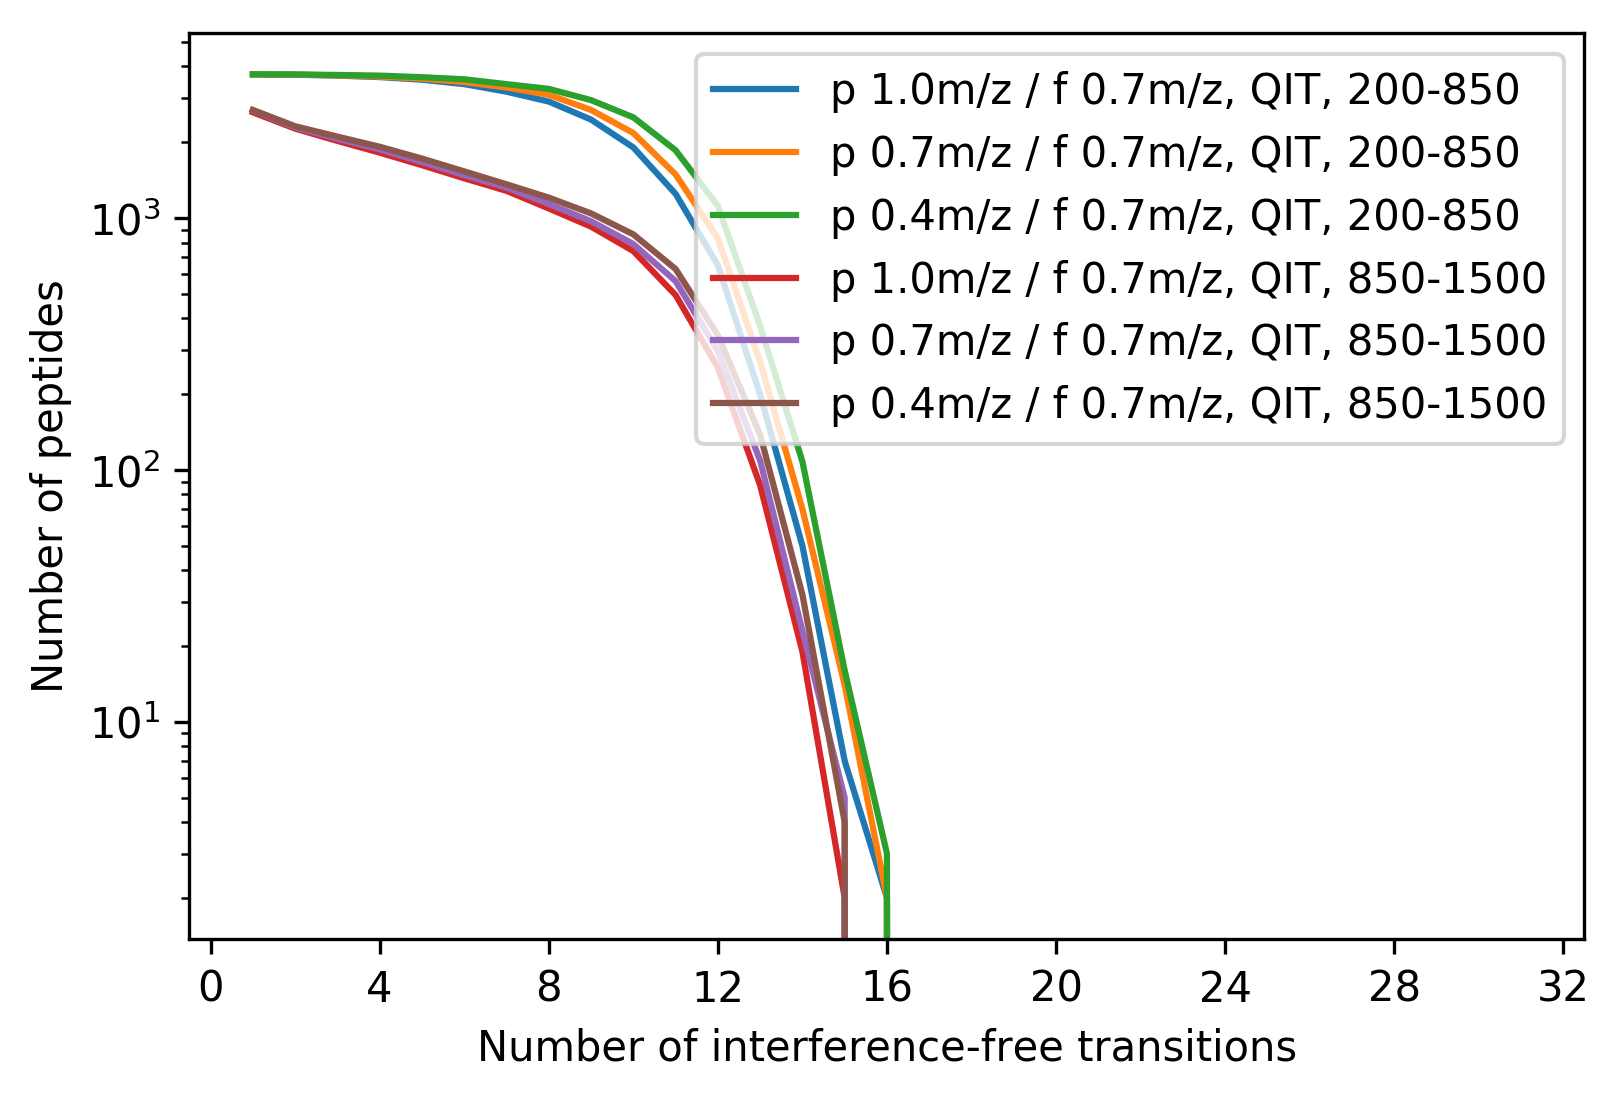

In [59]:
import matplotlib.ticker as ticker
from itertools import chain

runs = [
    {
        'precursor_width': 1.0,
        'fwhm_at_400': 0.7,
        'mass_analyzer_type': 'QIT',
        'fragment_mz_start': 200,
        'fragment_mz_end': 850,
    },
    {
        'precursor_width': 0.7,
        'fwhm_at_400': 0.7,
        'mass_analyzer_type': 'QIT',
        'fragment_mz_start': 200,
        'fragment_mz_end': 850,
    },
    {
        'precursor_width': 0.4,
        'fwhm_at_400': 0.7,
        'mass_analyzer_type': 'QIT',
        'fragment_mz_start': 200,
        'fragment_mz_end': 850,
    },
    {
        'precursor_width': 1.0,
        'fwhm_at_400': 0.7,
        'mass_analyzer_type': 'QIT',
        'fragment_mz_start': 850,
        'fragment_mz_end': 1500,
    },
    {
        'precursor_width': 0.7,
        'fwhm_at_400': 0.7,
        'mass_analyzer_type': 'QIT',
        'fragment_mz_start': 850,
        'fragment_mz_end': 1500,
    },
    {
        'precursor_width': 0.4,
        'fwhm_at_400': 0.7,
        'mass_analyzer_type': 'QIT',
        'fragment_mz_start': 850,
        'fragment_mz_end': 1500,
    }
]
for run in runs:
    kwargs = run
    uninterfered_frag_counts_df = find_interference_free_transitions(g_precursors_df, g_fragments_df,
                                                                     precursor_mz_start, precursor_mz_end,
                                                                     engine=g_engine, **kwargs)
    mass_analyzer_type = kwargs['mass_analyzer_type']
    precursor_width = kwargs['precursor_width']
    if mass_analyzer_type == 'QIT' or mass_analyzer_type == 'Quad':
        resolution_type = 'm/z'
        resolution = kwargs['fwhm_at_400']
    elif mass_analyzer_type == 'Orbitrap':
        resolution_type = ''
        resolution = kwargs['resolving_power_at_400']
    else:
        raise Exception('Unknown mass analyzer type ' + mass_analyzer_type)
    plt.plot(xrange(1, 32), [uninterfered_frag_counts_df.loc[uninterfered_frag_counts_df['TransitionCount'] > x].shape[0] for x in xrange(0, 31)],
            label="p {}m/z / f {}{}, {}, {}-{}".format(precursor_width, resolution, resolution_type, mass_analyzer_type,
                                                      kwargs['fragment_mz_start'], kwargs['fragment_mz_end']))
plt.xlabel("Number of interference-free transitions")
plt.ylabel("Number of peptides")
plt.yscale('log')
plt.legend()
axes = plt.gca()
axes.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
fig = plt.gcf()
fig.set_dpi(300.0)
plt.show()


100.0%

100.0%

38.8%

KeyboardInterrupt: 

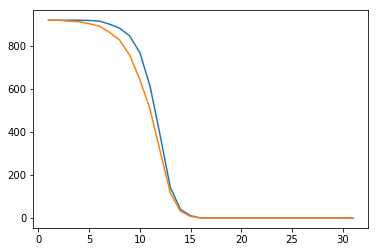

In [216]:
import matplotlib.ticker as ticker
from itertools import chain

g_precursor_mz_start = 400.0
g_precursor_mz_end = 1000.0
g_fragment_mz_start = 200.0
g_fragment_mz_end = 1500.0

runs = [
    {
        'precursor_width': 0.7,
        'fwhm_at_400': 0.7,
        'mass_analyzer_type': 'Quad',
        'fragment_mz_start': 0,
        'fragment_mz_end': 750,
    },
    {
        'precursor_width': 0.7,
        'fwhm_at_400': 1.0,
        'mass_analyzer_type': 'Quad',
        'fragment_mz_start': 0,
        'fragment_mz_end': 750,
    },
    {
        'precursor_width': 0.7,
        'fwhm_at_400': 0.7,
        'mass_analyzer_type': 'Quad',
        'fragment_mz_start': 750,
        'fragment_mz_end': 1500,
    },
    {
        'precursor_width': 0.7,
        'fwhm_at_400': 1.0,
        'mass_analyzer_type': 'Quad',
        'fragment_mz_start': 750,
        'fragment_mz_end': 1500,
    }
]
for run in runs:
    kwargs = run
    uninterfered_frag_counts_df = find_interference_free_transitions(g_precursors_df, g_fragments_df,
                                                                     g_precursor_mz_start, g_precursor_mz_end,
                                                                     engine=g_engine, **kwargs)
    mass_analyzer_type = kwargs['mass_analyzer_type']
    precursor_width = kwargs['precursor_width']
    if mass_analyzer_type == 'QIT' or mass_analyzer_type == 'Quad':
        resolution_type = 'm/z'
        resolution = kwargs['fwhm_at_400']
    elif mass_analyzer_type == 'Orbitrap':
        resolution_type = ''
        resolution = kwargs['resolving_power_at_400']
    else:
        raise Exception('Unknown mass analyzer type ' + mass_analyzer_type)
    plt.plot(xrange(1, 32), [uninterfered_frag_counts_df.loc[uninterfered_frag_counts_df['TransitionCount'] > x].shape[0] for x in xrange(0, 31)],
            label="p {}m/z / f {}{}, {}, {}-{}".format(precursor_width, resolution, resolution_type, mass_analyzer_type,
                                                      kwargs['fragment_mz_start'], kwargs['fragment_mz_end']))
plt.xlabel("Number of interference-free transitions")
plt.ylabel("Number of peptides")
plt.yscale('log')
plt.legend()
axes = plt.gca()
axes.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
fig = plt.gcf()
fig.set_dpi(300.0)
fig.tight_layout()
plt.savefig("Product range difference.png")

plt.show()

## Additional Plots for Mike's Proposal

*2017-09-07*

Mike:
> Can I get the Figure 1 redone with:

> 24 m/z / 30000 RP Orbitrap

> 12 m/z / 30000 RP Orbitrap

> 4 m/z / 0.7 m/z QIT

> 2 m/z / 0.7 m/z QIT

> Can I get these as 4 solid lines in different colors?

> Actually another idea for the colors ... maybe 4 different colors but also make the Orbitrap lines dashed like you did in your original figure.

In [224]:
kwargs = {
    'precursor_width': 0.7,
    'fwhm_at_400': 0.7,
    'mass_analyzer_type': 'QIT'
}

g_precursor_mz_start = 400.0
g_precursor_mz_end = 1000.0
g_fragment_mz_start = 200.0
g_fragment_mz_end = 1500.0

prop_cycle = list(plt.rcParams['axes.prop_cycle'])

runs = [
    {
        'precursor_width': 24.0,
        'resolving_power_at_400': 60000.0,
        'mass_analyzer_type': 'Orbitrap',
        'style': ''
    },
    {
        'precursor_width': 12.0,
        'resolving_power_at_400': 60000.0,
        'mass_analyzer_type': 'Orbitrap',
        'style': ''
    },
    {
        'precursor_width': 4.0,
        'fwhm_at_400': 0.7,
        'mass_analyzer_type': 'QIT',
        'style': ''
    },
    {
        'precursor_width': 2.0,
        'fwhm_at_400': 0.7,
        'mass_analyzer_type': 'QIT',
        'style': ''
    }
]

m_plotstyle = {}
for i, m in enumerate(['QIT', 'Orbitrap']):
    m_plotstyle[m] = {'linestyle': '--', 'dashes': '' if i == 0 else (5 - 2*i, i * 3)}
    
for i, run in enumerate(runs):
    kwargs = run
    plotstyle_args = {'color': prop_cycle[i]['color']}
    for key in m_plotstyle[kwargs['mass_analyzer_type']].keys():
        plotstyle_args[key] = m_plotstyle[kwargs['mass_analyzer_type']][key]
    uninterfered_frag_counts_df = find_interference_free_transitions(g_precursors_df, g_fragments_df,
                                                                     g_precursor_mz_start, g_precursor_mz_end,
                                                                     fragment_mz_start=g_fragment_mz_start,
                                                                     fragment_mz_end=g_fragment_mz_end,
                                                                     engine=g_engine, regenerate=False,
                                                                     **kwargs)
    mass_analyzer_type = kwargs['mass_analyzer_type']
    precursor_width = kwargs['precursor_width']
    if mass_analyzer_type == 'QIT':
        resolution_type = 'm/z'
        resolution = kwargs['fwhm_at_400']
    elif mass_analyzer_type == 'Orbitrap':
        resolution_type = ''
        resolution = kwargs['resolving_power_at_400']
    else:
        raise Exception('Unknown mass analyzer type ' + mass_analyzer_type)
    label = "{} m/z{} / {}{} {}".format(precursor_width * 2 if kwargs['style'] == 'overlap' else precursor_width,
                                              ' overlap' if kwargs['style'] == 'overlap' else '',
                                              int(resolution) if mass_analyzer_type == 'Orbitrap' else resolution,
                                              ' m/z' if resolution_type == 'm/z' else '',
                                              mass_analyzer_type)
    plt.plot([uninterfered_frag_counts_df.loc[uninterfered_frag_counts_df['TransitionCount'] > x].shape[0] for x in xrange(1, 20)],
            label=label,
            **plotstyle_args)
plt.xlabel("Number of interference-free transitions")
plt.ylabel("Number of peptides")
plt.yscale('log')
plt.legend()
axes = plt.gca()
axes.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
fig = plt.gcf()
fig.set_dpi(2400.0)
#fig.set_dpi(200.0)
fig.savefig('orbitrap_and_qit_experimental.png')
plt.show()